In [1]:
import numpy as np
import sympy as sp
from qutip import Qobj
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from schedule import generate_local_adiabatic_pulse, find_eigen, Schedule, run
from math import ceil, floor

d:\anaconda3\envs\qubit-reset\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def npad_rot(h, j, k):
    delta_jk = 0.5 * (h[j, j] - h[k, k])
    g_jk = h[j, k]
    theta = np.arctan(g_jk / delta_jk)
    c_jk = np.cos(theta / 2)
    s_jk = np.sin(theta / 2)
    u_jk = np.zeros_like(h, dtype=complex)
    np.fill_diagonal(u_jk, 1. + 0j)
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.conj().T
    if h_pr[j, j] > h_pr[k, k]:
        h_pr[:, [j, k]] = h_pr[:, [k, j]]
        h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

def npad_num(h_list, rot_seq: list):
    for pair in rot_seq:
        h_list = [npad_rot(h, pair[0], pair[1]) for h in h_list]
    return h_list

def plot_h(x, h_list):
    energies_3ls_list = []
    for h in h_list:
        energies = Qobj(h).diag()
        energies_3ls_list.append(energies)
    energies_3ls_mat = np.array(energies_3ls_list).T

    plt.plot(x, energies_3ls_mat[0])
    plt.plot(x, energies_3ls_mat[1])
    
    return energies_3ls_mat

def plot_eigen(x, h_list, plot_step=1, marker='.'):
    eigen_3ls_energies = []
    for _h in h_list:
        h_qobj = Qobj(_h)
        energies = h_qobj.eigenenergies()
        eigen_3ls_energies.append(energies)
    eigen_3ls_energies_mat = np.array(eigen_3ls_energies).T
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[0][::plot_step], marker)
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[1][::plot_step], marker)
    return eigen_3ls_energies_mat

def fit_tls_diff_simple(x, g, b, scale):
    return 2 * scale * np.sqrt((x - b) ** 2 + g ** 2)

def fit_tls(x, g, scale):
    return scale * np.sqrt(x ** 2 + g ** 2)

def fit_lin(x, k, b):
    return k * x + b

In [3]:
seq1 = [[0, 2], [1, 2]]
seq2 = [[1, 2], [0, 2]]

In [4]:
g_qc_val = 50e-3
g_val = np.sqrt(2) * g_qc_val
a_val = -256e-3
# delta_qc_sweep = np.linspace(-20 * g_val, 20 * g_val, 100)
delta_sweep = np.linspace(-1.5 * g_val, 1.5 * g_val, 100)

def ham_3ls_delta(delta, g, a_val):
    h_mat = np.array([
    [delta, 0, g],
    [0, -delta, g], 
    [g, g, -0.5 * a_val]
    ], dtype=complex)
    return h_mat

h0 = [ham_3ls_delta(d, g_val, a_val) for d in delta_sweep]

In [5]:
h1 = npad_num(h0, rot_seq=seq1)
h2 = npad_num(h0, rot_seq=seq2)

h1_eff = [h[0:2, 0:2] for h in h1]
h2_eff = [h[0:2, 0:2] for h in h2]

In [6]:
h3 = 0.5 * (np.array(h1_eff) + np.array(h2_eff))

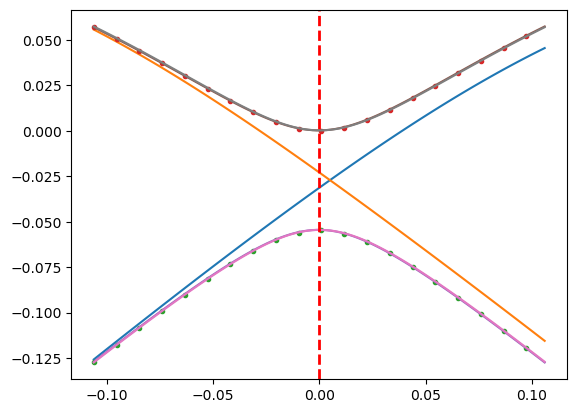

In [7]:


energies = plot_h(delta_sweep, h1_eff)
# plot_h(delta_sweep, h3)



eigen_mat = plot_eigen(delta_sweep, h0, plot_step=5)
# h3_mat = plot_eigen(delta_sweep, h3, marker='-')


h1_mat = plot_eigen(delta_sweep, h1_eff, marker='-')
h2_mat = plot_eigen(delta_sweep, h2_eff, marker='-')

plt.axvline(x=0., color='r', linestyle='--', linewidth=2)
plt.show()

In [8]:
diff1 = h1_mat[1] - h1_mat[0]
diff2 = h2_mat[1] - h2_mat[0]
para_tls_eigen, pcov = curve_fit(fit_tls_diff_simple, delta_sweep, diff1)
g_tls, b_tls, scale_tls = para_tls_eigen[0], para_tls_eigen[1], para_tls_eigen[2]

diff_fit = fit_tls_diff_simple(delta_sweep, g_tls, 0., scale_tls)
diff_eigen = eigen_mat[1] - eigen_mat[0]
# diff3 = h3_mat[1] - h3_mat[0]

print(g_tls, b_tls, scale_tls)

0.033123237497130184 -0.00026004044161434086 0.8375134110768723


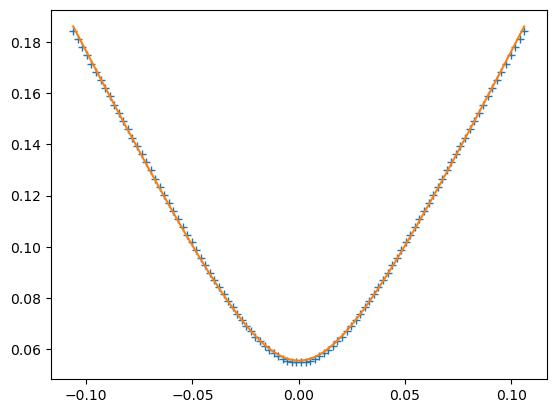

In [9]:
# plt.plot(delta_sweep, eigen_mat[1] - eigen_mat[0], '.')
# plt.plot(delta_sweep, diff1, '--')
# plt.plot(delta_sweep, diff3, '-')

plt.plot(delta_sweep, diff_eigen, '+')
plt.plot(delta_sweep, diff_fit, '-')


plt.show()

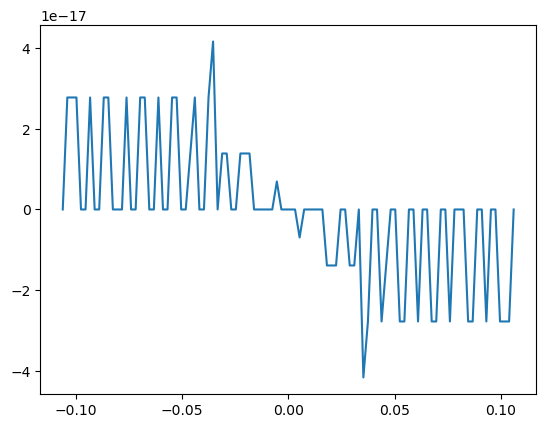

In [10]:
plt.plot(delta_sweep, diff_fit - diff_fit[::-1])
# plt.plot(delta_sweep, diff_eigen - diff_eigen[::-1], '.')
plt.show()


# Symbol 

In [11]:
import sympy as sp
from sympy.assumptions.refine import refine_abs, refine

In [12]:
def ham_3ls(omega1, omega2, g, alpha1, alpha2):
    h_mat = np.array([
    [2 * omega1 + alpha1, g, 0],
    [g, omega1 + omega2, g],
    [0, g, 2 * omega2 + alpha2]
], dtype=complex)
    return h_mat


def ham_tls2(freq_c, freq_q, g):
    h_mat = np.array([
    [freq_q, g],
    [g, freq_c] 
    ], dtype=complex)
    return h_mat

def ham_tls(detuning, g):
    h_mat = np.array([
        [detuning, g],
        [g, -detuning] 
    ], dtype=complex)
    return h_mat

def npad_rot(h, j, k):
    delta_jk = 0.5 * (h[j, j] - h[k, k])
    g_jk = h[j, k]
    theta = np.arctan(g_jk / delta_jk)
    c_jk = np.cos(theta / 2)
    s_jk = np.sin(theta / 2)
    u_jk = np.zeros_like(h, dtype=complex)
    np.fill_diagonal(u_jk, 1. + 0j)
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.conj().T
    if h_pr[j, j] > h_pr[k, k]:
        h_pr[:, [j, k]] = h_pr[:, [k, j]]
        h_pr[[j, k], :] = h_pr[[k, j], :]
    return h_pr

def npad_rot_sym(h, j, k, return_rot=False):
    delta_jk =  (h[j, j] - h[k, k]) / 2
    g_jk = h[j, k]
    theta = sp.atan(g_jk / delta_jk)
    c_jk = sp.cos(theta / 2)
    s_jk = sp.sin(theta / 2)
    u_jk = sp.eye(h.shape[0], h.shape[1])
    u_jk[j, j] = c_jk
    u_jk[k, k] = c_jk
    u_jk[j, k] = s_jk
    u_jk[k, j] = -s_jk
    h_pr = u_jk @ h @ u_jk.T
    # if h_pr[j, j] > h_pr[k, k]:
    #     h_pr[:, [j, k]] = h_pr[:, [k, j]]
    #     h_pr[[j, k], :] = h_pr[[k, j], :]
    if return_rot is True:
        return h_pr, u_jk
    else:
        return h_pr

In [13]:
wq = sp.Symbol('wq', positive=True, real=True, dtype=float)
wc = sp.Symbol('wc', positive=True, real=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)
a = sp.Symbol('α', positive=False, real=True, dtype=float)
b = sp.Symbol('β', positive=False, real=True, dtype=float)
delta = sp.Symbol('Δ', real=True, dtype=float)
del1 = sp.Symbol('δ1', real=True, positive=True, dtype=float)
gamma = sp.Symbol('γ', real=True, positive=False, dtype=float)

del1_alpha = (del1, -a/2)


h0 = sp.Matrix([
[delta,      0,            g],
[0,       -delta,          g],
[g,            g,    del1]])

h_swt_tls_approx = sp.Matrix([
[(1 - g ** 2 / del1 ** 2) * delta, -g**2/del1],
[-g**2/del1, (-1 + g ** 2 / del1 ** 2) * delta]])
h0

Matrix([
[Δ,  0,  g],
[0, -Δ,  g],
[g,  g, δ1]])

In [14]:
h_swt_tls_approx = h_swt_tls_approx.subs([del1_alpha])
h_swt_tls_approx

Matrix([
[Δ*(-4*g**2/α**2 + 1),            2*g**2/α],
[            2*g**2/α, Δ*(4*g**2/α**2 - 1)]])

In [15]:
diff_tls_swt_sym = 2 * sp.sqrt(h_swt_tls_approx[0, 0] ** 2 + h_swt_tls_approx[0, 1] ** 2)
g_eff_swt = h_swt_tls_approx[0, 1]
g_eff_swt

2*g**2/α

In [16]:
delta1 = sp.Symbol('Δ1', real=True, dtype=float)
shift1 = (h0[0, 0] + h0[2, 2]) / 2
h0_shift= h0 - shift1 * sp.eye(3)
delta1_delta = (delta1, delta / 2 - del1 / 2)
delta_delta1 = (delta, 2 * delta1 + del1)

h0_input = h0_shift.subs([delta_delta1])

In [17]:
h0_shift

Matrix([
[Δ/2 - δ1/2,             0,           g],
[         0, -3*Δ/2 - δ1/2,           g],
[         g,             g, -Δ/2 + δ1/2]])

In [18]:
h1, r1 = npad_rot_sym(h0_input, 0, 2, return_rot=True)
h1 = sp.simplify(h1)
h1 = sp.simplify(h1)
h1 = sp.refine(h1, sp.Q.negative(delta1))

h1

Matrix([
[-sqrt(g**2 + Δ1**2), g*sin(atan(g/Δ1)/2),                   0],
[g*sin(atan(g/Δ1)/2),        -3*Δ1 - 2*δ1, g*cos(atan(g/Δ1)/2)],
[                  0, g*cos(atan(g/Δ1)/2),  sqrt(g**2 + Δ1**2)]])

In [19]:
r1

Matrix([
[ cos(atan(g/Δ1)/2), 0, sin(atan(g/Δ1)/2)],
[                 0, 1,                 0],
[-sin(atan(g/Δ1)/2), 0, cos(atan(g/Δ1)/2)]])

In [20]:
shift2 = (h1[1, 1] + h1[2, 2]) / 2
delta2 = sp.Symbol('Δ2', positive=True, real=True, dtype=float)
s1 = sp.Symbol('s1', real=True, dtype=float)
c1 = sp.Symbol('c1', real=True, dtype=float)

s1_delta1 = (s1, sp.sin(sp.atan(g / delta1) / 2))
c1_delta1 = (c1, sp.cos(sp.atan(g / delta1) / 2))

delta1_s1 = s1_delta1[::-1]
delta1_c1 = c1_delta1[::-1]



delta2_delta1 = (delta2, h1[2, 2] - shift2)
delta1_delta2 = (h1[2, 2] - shift2, delta2)

h1_shift = h1 - shift2 * sp.eye(3)

h1_input = h1_shift.subs([delta1_delta2, delta1_c1, delta1_s1])

In [21]:
h1_shift

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2,                 g*sin(atan(g/Δ1)/2),                                  0],
[                 g*sin(atan(g/Δ1)/2), -3*Δ1/2 - δ1 - sqrt(g**2 + Δ1**2)/2,                g*cos(atan(g/Δ1)/2)],
[                                   0,                 g*cos(atan(g/Δ1)/2), 3*Δ1/2 + δ1 + sqrt(g**2 + Δ1**2)/2]])

In [22]:
h1_input

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2, g*s1,    0],
[                                g*s1,  -Δ2, c1*g],
[                                   0, c1*g,   Δ2]])

In [23]:
h1[2, 2] - shift2

3*Δ1/2 + δ1 + sqrt(g**2 + Δ1**2)/2

In [24]:
h2, u2 = npad_rot_sym(h1_input, 1, 2, return_rot=True)
h2 = sp.simplify(h2)
h2 = sp.simplify(h2)
h2 = sp.refine(h2, sp.Q.positive(delta2))

h2

Matrix([
[3*Δ1/2 + δ1 - 3*sqrt(g**2 + Δ1**2)/2, g*s1*cos(atan(c1*g/Δ2)/2), g*s1*sin(atan(c1*g/Δ2)/2)],
[           g*s1*cos(atan(c1*g/Δ2)/2), -sqrt(c1**2*g**2 + Δ2**2),                         0],
[           g*s1*sin(atan(c1*g/Δ2)/2),                         0,  sqrt(c1**2*g**2 + Δ2**2)]])

In [25]:
u2

Matrix([
[1,                    0,                     0],
[0, cos(atan(c1*g/Δ2)/2), -sin(atan(c1*g/Δ2)/2)],
[0, sin(atan(c1*g/Δ2)/2),  cos(atan(c1*g/Δ2)/2)]])

In [26]:
h2[0, 0] / 2 - h2[1, 1] / 2

3*Δ1/4 + δ1/2 - 3*sqrt(g**2 + Δ1**2)/4 + sqrt(c1**2*g**2 + Δ2**2)/2

In [27]:
h_sym_eff = h2[0:2, 0:2]
# h_sym_eff = h_sym_eff.subs([s1_delta1, c1_delta1, delta2_delta1, delta1_delta, del1_alpha])
h_sym_eff = h_sym_eff.subs([s1_delta1, c1_delta1, delta2_delta1, delta1_delta, del1_alpha])
h_sym_eff 

Matrix([
[                                                                       3*Δ/4 - α/8 - 3*sqrt(g**2 + (Δ/2 + α/4)**2)/2, g*sin(atan(g/(Δ/2 + α/4))/2)*cos(atan(g*cos(atan(g/(Δ/2 + α/4))/2)/(3*Δ/4 - α/8 + sqrt(g**2 + (Δ/2 + α/4)**2)/2))/2)],
[g*sin(atan(g/(Δ/2 + α/4))/2)*cos(atan(g*cos(atan(g/(Δ/2 + α/4))/2)/(3*Δ/4 - α/8 + sqrt(g**2 + (Δ/2 + α/4)**2)/2))/2),                         -sqrt(g**2*cos(atan(g/(Δ/2 + α/4))/2)**2 + (3*Δ/4 - α/8 + sqrt(g**2 + (Δ/2 + α/4)**2)/2)**2)]])

In [28]:
g_symbol = h_sym_eff[1, 0]
delta3_symbol = h_sym_eff[0, 0] / 2 - h_sym_eff[1, 1] / 2

In [29]:
g_pr = sp.diff(h_sym_eff[1, 0], delta)
offset = g_symbol.subs(delta, 0)
k_g = g_pr.subs(delta, 0)
g_lin_sym = k_g * delta + offset

In [137]:
delta3_pr = sp.diff(delta3_symbol, delta)
delta3_offset = delta3_symbol.subs(delta, 0)
k_b = delta3_pr.subs(delta, 0)
b_lin_sym = k_b * delta + delta3_offset

In [142]:
alpha = sp.sqrt(k_g ** 2 + k_b ** 2)
x0 = (k_g * offset + k_b * delta3_offset) / (k_b ** 2 + k_g ** 2)
g_eff = sp.sqrt((offset ** 2 + delta3_offset ** 2) / alpha ** 2 - x0**2)
g_eff_2 = sp.sqrt((offset ** 2 + delta3_offset ** 2) / alpha ** 2)

diff_eff_sym = 2 * alpha * sp.sqrt(delta ** 2 + g_eff ** 2)
diff_eff_sym2 = 2 * alpha * sp.sqrt(delta ** 2 + g_eff_2 ** 2)


In [144]:
g_eff

sqrt((g**2*sin(atan(4*g/α)/2)**2*cos(atan(g*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2))/2)**2 + (-α/16 - 3*sqrt(g**2 + α**2/16)/4 + sqrt(g**2*cos(atan(4*g/α)/2)**2 + (-α/8 + sqrt(g**2 + α**2/16)/2)**2)/2)**2)/((-4*g**2*cos(atan(4*g/α)/2)*cos(atan(g*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2))/2)/(α**2*(16*g**2/α**2 + 1)) - g*(4*g**2*sin(atan(4*g/α)/2)/(α**2*(-α/8 + sqrt(g**2 + α**2/16)/2)*(16*g**2/α**2 + 1)) + g*(-α/(16*sqrt(g**2 + α**2/16)) - 3/4)*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2)**2)*sin(atan(4*g/α)/2)*sin(atan(g*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2))/2)/(2*(g**2*cos(atan(4*g/α)/2)**2/(-α/8 + sqrt(g**2 + α**2/16)/2)**2 + 1)))**2 + (-3*α/(32*sqrt(g**2 + α**2/16)) + 3/8 + (4*g**3*sin(atan(4*g/α)/2)*cos(atan(4*g/α)/2)/(α**2*(16*g**2/α**2 + 1)) + (-α/8 + sqrt(g**2 + α**2/16)/2)*(α/(8*sqrt(g**2 + α**2/16)) + 3/2)/2)/(2*sqrt(g**2*cos(atan(4*g/α)/2)**2 + (-α/8 + sqrt(g**2 + α**2/16)/2)**2)))**2) - (g*(-4*g**2*cos(atan(4*g/α)/2)*cos(atan(g*cos(ata

In [145]:
alpha

sqrt((-4*g**2*cos(atan(4*g/α)/2)*cos(atan(g*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2))/2)/(α**2*(16*g**2/α**2 + 1)) - g*(4*g**2*sin(atan(4*g/α)/2)/(α**2*(-α/8 + sqrt(g**2 + α**2/16)/2)*(16*g**2/α**2 + 1)) + g*(-α/(16*sqrt(g**2 + α**2/16)) - 3/4)*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2)**2)*sin(atan(4*g/α)/2)*sin(atan(g*cos(atan(4*g/α)/2)/(-α/8 + sqrt(g**2 + α**2/16)/2))/2)/(2*(g**2*cos(atan(4*g/α)/2)**2/(-α/8 + sqrt(g**2 + α**2/16)/2)**2 + 1)))**2 + (-3*α/(32*sqrt(g**2 + α**2/16)) + 3/8 + (4*g**3*sin(atan(4*g/α)/2)*cos(atan(4*g/α)/2)/(α**2*(16*g**2/α**2 + 1)) + (-α/8 + sqrt(g**2 + α**2/16)/2)*(α/(8*sqrt(g**2 + α**2/16)) + 3/2)/2)/(2*sqrt(g**2*cos(atan(4*g/α)/2)**2 + (-α/8 + sqrt(g**2 + α**2/16)/2)**2)))**2)

In [ ]:
diff_tls_swt_sym = diff_tls_swt_sym.subs([del1_alpha])


In [146]:

diff_eff_num = np.array([diff_eff_sym.subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep], dtype=float)
diff_eff_num2 = np.array([diff_eff_sym2.subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep], dtype=float)

dff_swt_num = np.array([diff_tls_swt_sym.subs({del1: del1_alpha, a: a_val, g: g_val, delta: d}) for d in delta_sweep], dtype=float)

In [147]:
h_sym_eff_num = [h_sym_eff.subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep]
g_sym_num = [h_sym_eff[0, 1].subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep]
diag_sym_num = [(0.5 * h_sym_eff[0, 0] - 0.5 * h_sym_eff[1, 1]).subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep]
g_lin_sym_num = np.array([g_lin_sym.subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep], dtype=float)
b_lin_sym_num = np.array([b_lin_sym.subs({a: a_val, g: g_val, delta: d}) for d in delta_sweep], dtype=float)

In [148]:
diff_fit = fit_tls_diff_simple(delta_sweep, g_tls, 0., scale_tls)

g_para_lin, g_cov_lin = curve_fit(fit_lin, delta_sweep, g_sym_num)
g_k_lin, g_b_lin = g_para_lin[0], g_para_lin[1]

diag_para_lin, diag_cov_lin = curve_fit(fit_lin, delta_sweep, diag_sym_num)
diag_k_lin, diag_b_lin = diag_para_lin[0], diag_para_lin[1]
print(g_k_lin, g_b_lin)

-0.1406875627282342 -0.02821318165196728


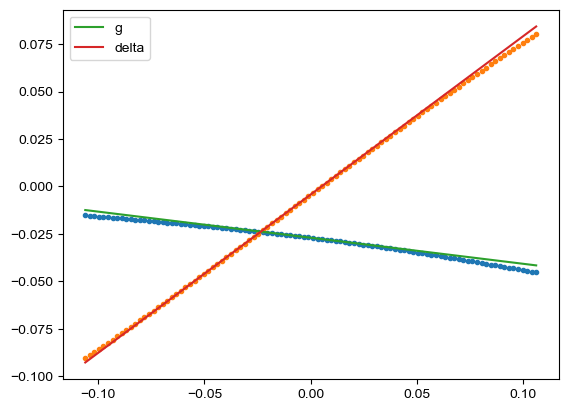

In [149]:
g_fit = fit_lin(delta_sweep, g_k_lin, g_b_lin)

delta_fit = fit_lin(delta_sweep, diag_k_lin, diag_b_lin)


plt.plot(delta_sweep, g_sym_num, '.')
plt.plot(delta_sweep, diag_sym_num, '.')

plt.plot(delta_sweep, g_lin_sym_num, '-', label='g')
plt.plot(delta_sweep, b_lin_sym_num, label='delta')


plt.legend()
plt.show()

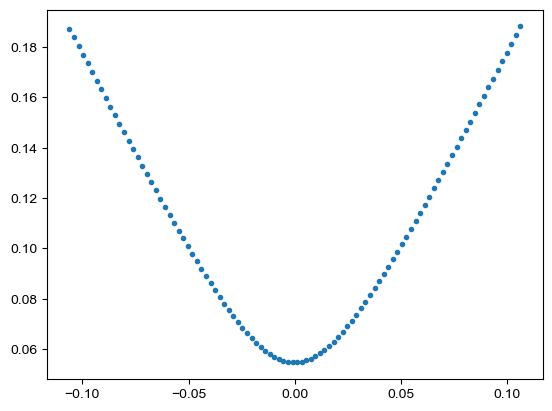

In [150]:
diff_lin_sym = 2 * np.sqrt(g_lin_sym_num ** 2 + b_lin_sym_num ** 2)
plt.plot(delta_sweep, diff_lin_sym, '.')
plt.show()

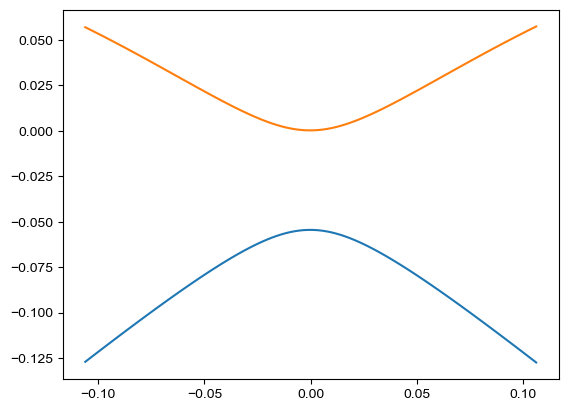

In [151]:
h_sym_mat = plot_eigen(delta_sweep, h1_eff, marker='-')

In [152]:
diff_sym_eigen = h_sym_mat[1] - h_sym_mat[0]

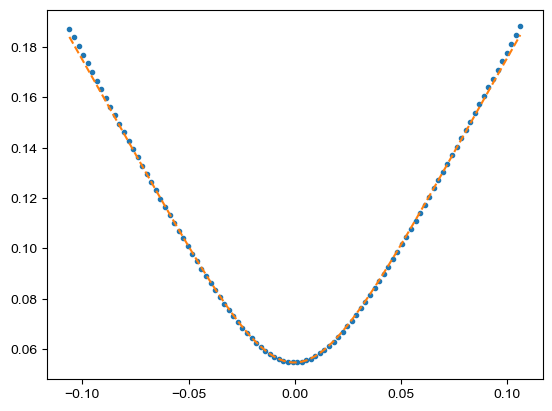

In [153]:
plt.plot(delta_sweep, diff_lin_sym, '.')
plt.plot(delta_sweep, diff_sym_eigen, '--')
plt.show()

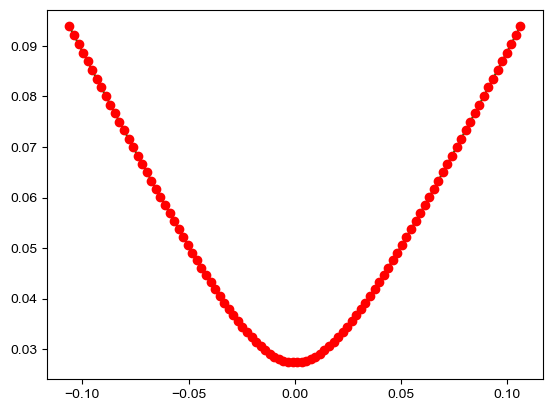

In [156]:
plt.plot(delta_sweep, 0.5 * diff_eff_num, '-', label='NPAD', color='green')
plt.plot(delta_sweep, 0.5 * diff_eff_num2, 'o', label='NPAD', color='red')
plt.show()

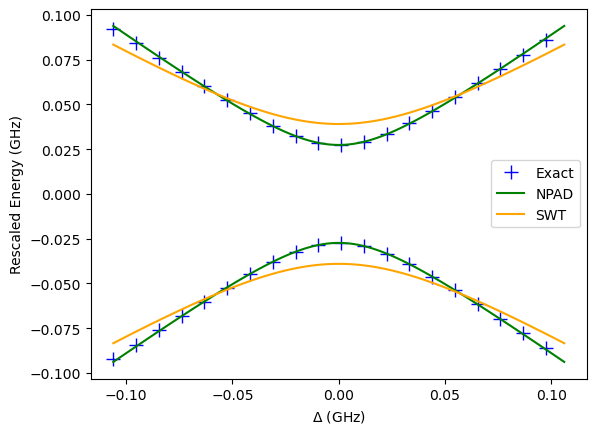

In [ ]:

# plt.plot(delta_sweep, diff_sym_eigen, '--')
plt.plot(delta_sweep[::5], 0.5 * diff_eigen[::5], '+', markersize=10, label='Exact', color='blue')
plt.plot(delta_sweep, 0.5 * diff_eff_num, '-', label='NPAD', color='green')
plt.plot(delta_sweep, 0.5 * dff_swt_num, label='SWT', color='orange')

plt.plot(delta_sweep[::5], -0.5 * diff_eigen[::5], '+', markersize=10, color='blue')
plt.plot(delta_sweep, -0.5 * diff_eff_num, '-', color='green')
plt.plot(delta_sweep, -0.5 * dff_swt_num, color='orange')

# plt.plot(delta_sweep, diff_fit, '-')a
plt.legend()
plt.xlabel(r'$\Delta$ (GHz)')
plt.ylabel('Rescaled Energy (GHz)')


plt.show()

In [44]:
def generate_local_adiabatic_pulse_swt(y0, yt, duration, g, dt, anharm, scale=1.0):
    g_eff_swt = 2 * g ** 2 / anharm
    delta_eff0 = y0 * (1 - 4 * g ** 2 / anharm ** 2)
    delta_efft = yt * (1 - 4 * g ** 2 / anharm ** 2)
    delta_eff = generate_local_adiabatic_pulse(g=scale * abs(g_eff_swt), T=duration, y0=delta_eff0, yt=delta_efft, dt=dt)
    delta = delta_eff / (1 - 4 * g ** 2 / anharm ** 2)
    time_array = np.linspace(0, duration, len(delta))
    return time_array, delta

def generate_local_adiabatic_pulse_npad(y0, yt, duration, g_eff_npad, chi, dt, scale=1.0):
    delta_eff = generate_local_adiabatic_pulse(g=scale * chi * g_eff_npad, T=duration, y0=chi*y0, yt=chi*yt, dt=dt)
    delta = delta_eff / chi
    time_array = np.linspace(0, duration, len(delta))
    return time_array, delta


In [45]:
# SWT
dt = 0.1
duration = 40

# delta0 = delta_sweep[0]
# deltat = delta_sweep[-1]

delta0 = -5 * g_val
deltat = +5 * g_val

g_scale_swt = 1.0
time, delta_swt = generate_local_adiabatic_pulse_swt(delta0, deltat, duration, g_val, dt, anharm=a_val, scale=g_scale_swt)

In [46]:
chi_val = np.array(alpha.subs({a: a_val, g: g_val}), dtype=float)

In [47]:
# NPAD
g_eff_npad_val = float(g_eff.subs({a: a_val, g: g_val}))
g_eff_npad_val = np.array(g_eff_npad_val)
chi_val = np.array(alpha.subs({a: a_val, g: g_val}), dtype=float)
g_scale = 1.0
time, delta_npad = generate_local_adiabatic_pulse_npad(delta0, deltat, duration, g_eff_npad=g_scale * g_eff_npad_val, chi=chi_val, dt=dt)


In [48]:
print(chi_val)
print(g_eff_npad_val)

0.8464343978741626
0.032319276334945704


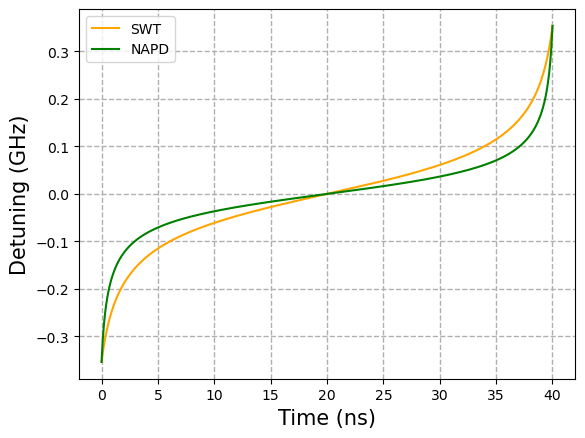

In [49]:
plt.plot(time, delta_swt, label='SWT', color='orange')
plt.plot(time, delta_npad, label='NAPD', color='green')
plt.xlabel('Time (ns)', size=15)
plt.ylabel(r'Detuning (GHz)', size=15)
plt.grid(linestyle = '--', linewidth = 1.0)
plt.legend()
plt.show()

$$
\Delta = \omega_q - \omega_c + \alpha / 2
$$

In [50]:
from qutip import tensor, qeye, destroy, basis
from numpy import pi

fq = 5176.667e-3  # qubit 1 frequency
anharm_q = -256.0e-3  # anharmonicity 1
anharm_c = 0.e-3  # anharmonicity 2
g_qc_val = 50e-3


# fc0 = 6552.000e-3  # coupler starting frequency
# fct = 4734.667e-3

fc0 = - delta0 + fq + 0.5 * anharm_q
fct = - deltat + fq + 0.5 * anharm_q

# Levels
qubit_levels = 3
coupler_levels = 3

# Operators
b = tensor(destroy(qubit_levels), qeye(coupler_levels))
c = tensor(qeye(qubit_levels), destroy(coupler_levels))

# Uncoupled Hamiltonian
H0 = fq * 2 * pi * b.dag() * b + 0.5 * anharm_q * 2 * pi * b.dag() * b.dag() * b * b + fc0 * 2 * pi * c.dag() * c + 0.5 * anharm_c * 2 * pi * c.dag() * c.dag() * c * c 

# Interaction Hamiltonian
H1 = g_val * 2 * pi * (b.dag() * c + b * c.dag())

# Coupled Hamiltonian
H2 = H0 + H1

# Control term for tuning up the coupler frequency
Hd = 2 * pi * c.dag() * c

psi_q_0 = basis(qubit_levels, 0)
psi_q_1 = basis(qubit_levels, 1)
psi_q_2 = basis(qubit_levels, 2)

psi_c_0 = basis(coupler_levels, 0)
psi_c_1 = basis(coupler_levels, 1)
psi_c_2 = basis(coupler_levels, 2)

psi_init_00 = tensor(psi_q_0, psi_c_0)
psi_init_10 = tensor(psi_q_1, psi_c_0)
psi_init_01 = tensor(psi_q_0, psi_c_1)
psi_init_11 = tensor(psi_q_1, psi_c_1)
psi_init_02 = tensor(psi_q_0, psi_c_2)
psi_init_20 = tensor(psi_q_2, psi_c_0)

H2_eigen_energies = H2.eigenstates()[0]
H2_eigen_states = H2.eigenstates()[1]
psi_init_20_eigen, _, idx_20 = find_eigen(psi_init_20, H2_eigen_states, H2_eigen_energies)
psi_init_11_eigen, _, _ = find_eigen(psi_init_11, H2_eigen_states, H2_eigen_energies)
psi_init_02_eigen, _, _ = find_eigen(psi_init_02, H2_eigen_states, H2_eigen_energies)
psi_init_10_eigen, _, _ = find_eigen(psi_init_10, H2_eigen_states, H2_eigen_energies)

psi_init = psi_init_20_eigen
# psi_init = psi_init_20


In [51]:
pulse_arr_ct_c0_swt = - delta_swt + fq + 0.5 * anharm_q - fc0
pulse_arr_ct_c0_npad = - delta_npad + fq + 0.5 * anharm_q - fc0
time = np.linspace(0, duration, len(pulse_arr_ct_c0_swt))

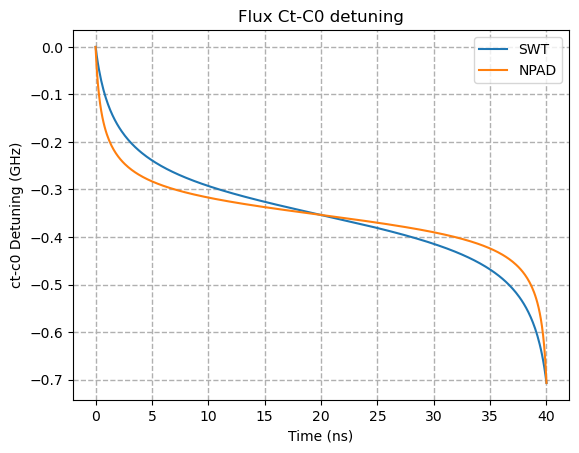

In [52]:
plt.plot(time, pulse_arr_ct_c0_swt, label=r'SWT')
plt.plot(time, pulse_arr_ct_c0_npad, label=r'NPAD')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('ct-c0 Detuning (GHz)')
plt.title('Flux Ct-C0 detuning')
plt.show()

40.0
400


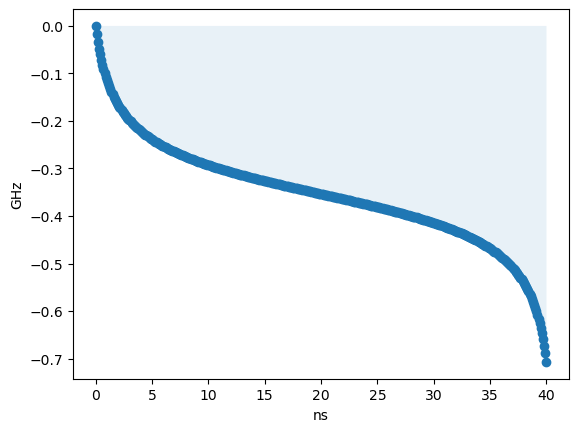

In [53]:
sched_swt = Schedule(sampling_rate=dt) 
sched_npad = Schedule(sampling_rate=dt)

sched_swt.append_list(list(pulse_arr_ct_c0_swt))
sched_swt.plot()

sched_npad.append_list(list(pulse_arr_ct_c0_npad))
# sched_tls2.plot()

In [54]:
H_swt = [H2, [Hd, sched_swt.sequence[::1]]]
expt_op_adia = [psi_init_10_eigen * psi_init_10_eigen.dag(), psi_init_20_eigen * psi_init_20_eigen.dag(), psi_init_11_eigen * psi_init_11_eigen.dag(), psi_init_02_eigen * psi_init_02_eigen.dag()]
times_swt = np.linspace(0, sched_swt.time, len(sched_swt.sequence))

exp_vals_swt, overlap_swt = run(H0=H_swt[0], Ht=H_swt[1], times=times_swt, psi_init=psi_init, e_ops=expt_op_adia, eigen_idx=[3, 4, 5])

In [55]:
H_napd = [H2, [Hd, sched_npad.sequence[::1]]]
expt_op_adia_napd = [psi_init_10_eigen * psi_init_10_eigen.dag(), psi_init_20_eigen * psi_init_20_eigen.dag(), psi_init_11_eigen * psi_init_11_eigen.dag(), psi_init_02_eigen * psi_init_02_eigen.dag()]
times_napd = np.linspace(0, sched_npad.time, len(sched_npad.sequence))

exp_vals_napd, overlap_napd = run(H0=H_napd[0], Ht=H_napd[1], times=times_napd, psi_init=psi_init, e_ops=expt_op_adia, eigen_idx=[3, 4, 5])

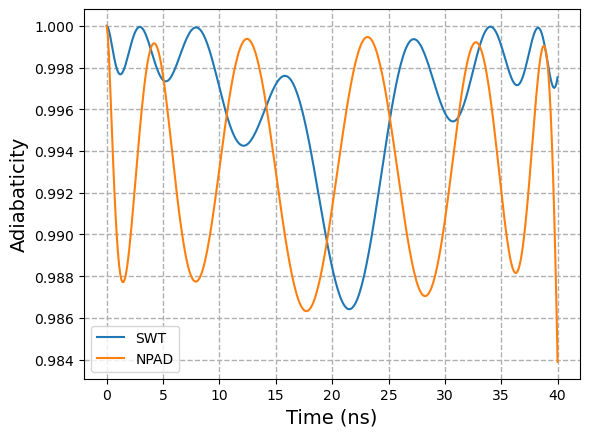

0.9975355844162633
0.9838859319122959


In [56]:
plt.plot(times_swt, overlap_swt[0], label=r'SWT')
plt.plot(times_napd, overlap_napd[0], label=r'NPAD')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.legend()
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Adiabaticity', fontsize=14)
# plt.title(rf'Sampling period = {dt} ns')
plt.show()
print(overlap_swt[0][-1])
print(overlap_napd[0][-1])


# 2D sweep

In [57]:
from qutip import tensor, qeye, destroy, basis, mesolve
from numpy import pi
from tqdm import tqdm
import pandas as pd

C:\Users\yzx\AppData\Local\Temp\ipykernel_36832\2039578135.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [58]:
def plot_bar(x_range, y_range, Z, label_bar='', label_x='', label_y='', title='', x_line=None, vmin=0., vmax=1., figsize=(5, 4), min2max=False):
    size = 20
    plt.figure(figsize=figsize)
    if min2max is not True:
        plt.imshow(Z, extent=(x_range.max(), x_range.min(), y_range.min(), y_range.max()), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(Z, extent=(x_range.min(), x_range.max(), y_range.min(), y_range.max()), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)

    cbar=plt.colorbar(label=label_bar)  # Add colorbar with label
    plt.xlabel(label_x, size=size)
    plt.ylabel(label_y, size=size)

    # 改变 colorbar label 大小
    cbar.set_label(label=label_bar, fontsize=15)
    cbar.ax.tick_params(labelsize=12)
    if x_line is not None:
        plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)

        # 在 x 轴下方标出该值
        plt.text(x_line, y_range.min() - (y_range.max() - y_range.min()) * 0.05,  # x轴下方稍微偏移
                    f'{x_line:.2f}', color='red', ha='center')
    
    x_ticks = np.linspace(x_range.min(), x_range.max(), num=5)
    y_ticks = np.linspace(y_range.min(), y_range.max(), num=5)

    plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=14)  # 可根据需要调整格式化
    plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=14)  # 可根据需要调整格式化
    
    plt.title(title, size=size)  
    # Show plot
    plt.tight_layout()
    plt.show()

def plot_bar2(x_range, y_range, Z, label_bar='', label_x='', label_y='', title='', x_ticks=False, x_line=None, vmin=0., vmax=1., figsize=(5, 4)):
    size = 20
    plt.figure(figsize=figsize)
    plt.imshow(Z, extent=(x_range.min(), x_range.max(), y_range.min(), y_range.max()), origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    cbar=plt.colorbar(label=label_bar, size=size)  # Add colorbar with label
    plt.xlabel(label_x, size=size)
    plt.ylabel(label_y, size=size)
    cbar.set_label("Colorbar Label", fontsize=12)
    if x_line is not None:
        plt.axvline(x=x_line, color='red', linestyle='--', linewidth=2)

        # 在 x 轴下方标出该值
        plt.text(x_line, y_range.min() - (y_range.max() - y_range.min()) * 0.05,  # x轴下方稍微偏移
                    f'{x_line:.0f}', color='red', ha='center')
    if x_ticks is True:
        x_ticks = np.linspace(x_range.min(), x_range.max(), num=5)
        plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks])  # 可根据需要调整格式化
    plt.title(title, size=size)  
    # Show plot
    plt.tight_layout()
    plt.show()

def return_z_line(x_sweep, y_sweep, Z, x_idx):
    # 将数据存入 pandas DataFrame
    X, Y = np.meshgrid(x_sweep, y_sweep)
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    Z_flat = Z.ravel()
    df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z': Z_flat})
    filtered_data = df[df['X'] == x_sweep[x_idx]]
    y_values = filtered_data['Y'].values
    z_values = filtered_data['Z'].values
    return y_values, z_values

In [59]:


fq0 = 5.176  # qubit 0 frequency
fq1 = 4.534  # qubit 1 frequency

# fq1 = 2.034  # qubit 1 frequency

fc0 = 6.034  # coupler initial freq

anharm_q0 = -256.0e-3  # anharmonicity 1
anharm_q1 = -158.0e-3  # anharmonicity 1

anharm_c = 0.e-3  # anharmonicity 2
g0c = 47e-3
g1c = 64e-3
# g1c = 0.e-3

dt = 0.2

# Levels
qubit_levels = 3
coupler_levels = 3

# Operators
a0 = tensor(destroy(qubit_levels), qeye(coupler_levels), qeye(qubit_levels))
a1 = tensor(qeye(qubit_levels), qeye(coupler_levels), destroy(qubit_levels))
b = tensor(qeye(qubit_levels), destroy(coupler_levels), qeye(qubit_levels))

# Uncoupled Hamiltonian
H0 = fq0 * 2 * pi * a0.dag() * a0 + 0.5 * anharm_q0 * 2 * pi * a0.dag() * a0.dag() * a0 * a0 + fq1 * 2 * pi * a1.dag() * a1 + 0.5 * anharm_q1 * 2 * pi * a1.dag() * a1.dag() * a1 * a1 + fc0 * 2 * pi * b.dag() * b + 0.5 * anharm_c * 2 * pi * b.dag() * b.dag() * b * b 

# Interaction Hamiltonian
H1 = g0c * 2 * pi * (a0.dag() * b + a0 * b.dag()) + g1c * 2 * pi * (a1.dag() * b + a1 * b.dag())

# Coupled Hamiltonian
H2 = H0 + H1

# Control term for tuning up the coupler frequency
Hd = 2 * pi * b.dag() * b

psi_q_0 = basis(qubit_levels, 0)
psi_q_1 = basis(qubit_levels, 1)
psi_q_2 = basis(qubit_levels, 2)

psi_c_0 = basis(coupler_levels, 0)
psi_c_1 = basis(coupler_levels, 1)
psi_c_2 = basis(coupler_levels, 2)

psi_init_000 = tensor(psi_q_0, psi_c_0, psi_q_0)
psi_init_100 = tensor(psi_q_1, psi_c_0, psi_q_0)
psi_init_001 = tensor(psi_q_0, psi_c_0, psi_q_1)

psi_init_010 = tensor(psi_q_0, psi_c_1, psi_q_0)
psi_init_110 = tensor(psi_q_1, psi_c_1, psi_q_0)
psi_init_020 = tensor(psi_q_0, psi_c_2, psi_q_0)
psi_init_200 = tensor(psi_q_2, psi_c_0, psi_q_0)
psi_init_002 = tensor(psi_q_0, psi_c_0, psi_q_2)

H2_eigen_energies = H2.eigenstates()[0]
H2_eigen_states = H2.eigenstates()[1]
psi_init_200_eigen, _, idx_20 = find_eigen(psi_init_200, H2_eigen_states, H2_eigen_energies)
psi_init_110_eigen, _, _ = find_eigen(psi_init_110, H2_eigen_states, H2_eigen_energies)
psi_init_020_eigen, _, _ = find_eigen(psi_init_020, H2_eigen_states, H2_eigen_energies)
psi_init_100_eigen, _, _ = find_eigen(psi_init_100, H2_eigen_states, H2_eigen_energies)
psi_init_010_eigen, _, _ = find_eigen(psi_init_010, H2_eigen_states, H2_eigen_energies)
psi_init_001_eigen, _, _ = find_eigen(psi_init_001, H2_eigen_states, H2_eigen_energies)
psi_init_002_eigen, _, _ = find_eigen(psi_init_002, H2_eigen_states, H2_eigen_energies)

psi_init = psi_init_200_eigen
# psi_init = psi_init_20


## sweep e reset

In [60]:
fct_sweep = np.linspace(5.300, 4.600, 30)
# g_scale_sweep = np.linspace(1, 5, 10)
duration_sweep = np.linspace(5, 50, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0
psi_init = psi_init_100_eigen
expt_op = [psi_init_100_eigen * psi_init_100_eigen.dag(), psi_init_010_eigen * psi_init_010_eigen.dag(), psi_init_001_eigen * psi_init_001_eigen.dag()]


In [61]:
# local adiabatic
X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_local_100 = np.zeros_like(X)
Z_local_010 = np.zeros_like(X)
Z_local_001 = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0
    yt = fq0 - fct_fc0 - fc0
    pulse_fq_fct_array = generate_local_adiabatic_pulse(g0c, duration, y0=y0, yt=yt, dt=dt)
    pulse_fct_fc0_array = - pulse_fq_fct_array + fq0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_local_100[_idx] = result.expect[0][-1]    
    Z_local_010[_idx] = result.expect[1][-1]    
    Z_local_001[_idx] = result.expect[2][-1]    


100%|██████████| 1200/1200 [01:53<00:00, 10.53it/s]


In [62]:
fq0

5.176

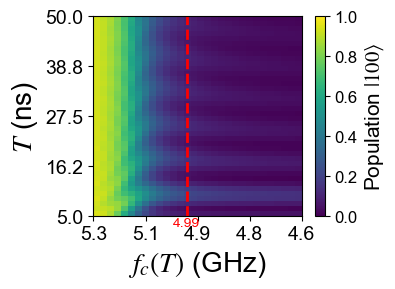

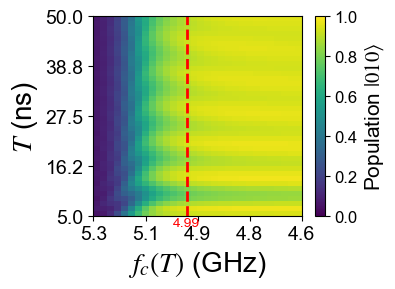

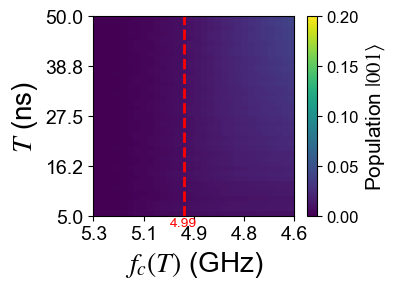

In [63]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'stix'
plot_bar(fct_sweep, duration_sweep, Z_local_100, x_line=4.986, label_x=r'${f_c(T)}$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|100\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_010, x_line=4.986, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|010\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_001, x_line=4.986, vmax=0.2, label_x=r'${f_c(T)}$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|001\rangle$', figsize=(4, 3))



In [64]:
Z_local_001.max()

0.040008180433771294

In [65]:
X_flat = X.ravel()
Y_flat = Y.ravel()
Z100_flat = Z_local_100.ravel()
Z010_flat = Z_local_010.ravel()
Z001_flat = Z_local_001.ravel()
target = 0.5 * Z100_flat + 0.5 * Z001_flat

# 将数据存入 pandas DataFrame
df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z100': Z100_flat, 'Z010': Z010_flat, 'Z001': Z001_flat, 'target': target})

# 找到 Z 最小值对应的行
min_z_row = df.loc[df['target'].idxmin()]

# 输出 Z 最小值及其对应的 X 和 Y 值
x_min, y_min, z_min = min_z_row['X'], min_z_row['Y'], min_z_row['target']
print(f"Z最小值为 {z_min}，对应的X值为 {x_min + fc0}，Y值为 {y_min}")

Z最小值为 0.0105941959335914，对应的X值为 4.6，Y值为 13.076923076923077


In [66]:
detunig_fct_fc0_sweep

array([-0.734     , -0.75813793, -0.78227586, -0.80641379, -0.83055172,
       -0.85468966, -0.87882759, -0.90296552, -0.92710345, -0.95124138,
       -0.97537931, -0.99951724, -1.02365517, -1.0477931 , -1.07193103,
       -1.09606897, -1.1202069 , -1.14434483, -1.16848276, -1.19262069,
       -1.21675862, -1.24089655, -1.26503448, -1.28917241, -1.31331034,
       -1.33744828, -1.36158621, -1.38572414, -1.40986207, -1.434     ])

In [67]:
detunig_fct_fc0_sweep + fc0
print(detunig_fct_fc0_sweep[13]+ fc0)


4.986206896551724


In [68]:
# 假设你想提取 X = 2 对应的一维数据
fct_value = 4.82452632

# 筛选出 X 值等于 2 的所有行
filtered_data = df[df['X'] == detunig_fct_fc0_sweep[13]]

# filtered_data = df[df['X'] == fq0 - fct_value]


# 提取对应的 Y 和 Z 列
y_values = filtered_data['Y'].values
z100_values = filtered_data['Z100'].values
z010_values = filtered_data['Z010'].values
z001_values = filtered_data['Z001'].values
error_vals = z100_values + z001_values

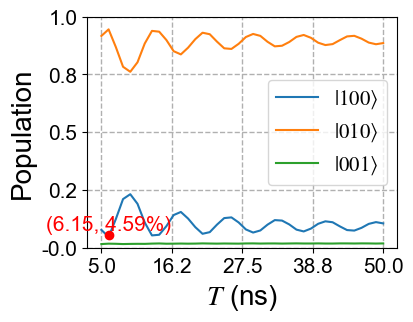

In [69]:
plt.figure(figsize=(4, 3))
plt.plot(y_values, z100_values, label=r'$|100\rangle$')
plt.plot(y_values, z010_values, label=r'$|010\rangle$')
plt.plot(y_values, z001_values, label=r'$|001\rangle$')

plt.grid(linestyle = '--', linewidth = 1.0)

size = 20

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)
# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error_vals)
min_index = np.argmin(error_vals)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5.0, y_values.max(), num=5)
y_ticks = np.linspace(0.0-0.01, 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15)  

plt.legend(fontsize=15)
plt.show()

Sweep g and duration

In [70]:
g_scale_sweep = np.linspace(0.5, 3.5, 30)

duration_sweep = np.linspace(5, 35, 40)
X, Y = np.meshgrid(g_scale_sweep, duration_sweep)


In [71]:
# local adiabatic
Z_reset_e_sta_100 = np.zeros_like(X)
Z_reset_e_sta_010 = np.zeros_like(X)
Z_reset_e_sta_001 = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    g_scale = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0
    yt = fq0 - 4.98
    pulse_fq_fct_array = generate_local_adiabatic_pulse(g_scale * g0c, duration, y0=y0, yt=yt, dt=dt)
    pulse_fct_fc0_array = - pulse_fq_fct_array + fq0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_reset_e_sta_100[_idx] = result.expect[0][-1]    
    Z_reset_e_sta_010[_idx] = result.expect[1][-1]    
    Z_reset_e_sta_001[_idx] = result.expect[2][-1]    


100%|██████████| 1200/1200 [00:24<00:00, 48.68it/s]


In [72]:
1000 * g_scale_sweep * g0c

array([ 23.5       ,  28.36206897,  33.22413793,  38.0862069 ,
        42.94827586,  47.81034483,  52.67241379,  57.53448276,
        62.39655172,  67.25862069,  72.12068966,  76.98275862,
        81.84482759,  86.70689655,  91.56896552,  96.43103448,
       101.29310345, 106.15517241, 111.01724138, 115.87931034,
       120.74137931, 125.60344828, 130.46551724, 135.32758621,
       140.18965517, 145.05172414, 149.9137931 , 154.77586207,
       159.63793103, 164.5       ])

In [73]:
g_idx = 14

In [74]:
print(1000 * g_scale_sweep[g_idx] * g0c)

91.56896551724138


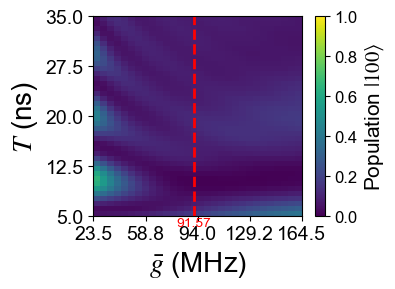

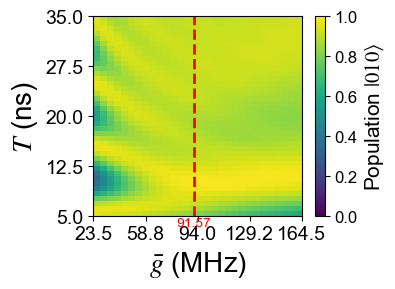

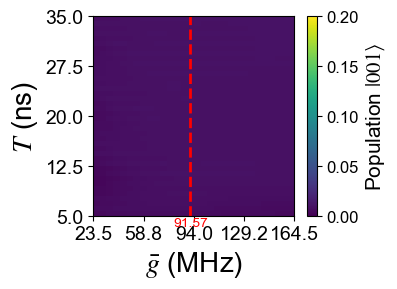

In [75]:
plot_bar(1000 * g_scale_sweep * g0c, duration_sweep, Z_reset_e_sta_100, x_line=1000 * g_scale_sweep[g_idx] * g0c, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|100\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1000 * g_scale_sweep * g0c, duration_sweep, Z_reset_e_sta_010, x_line=1000 * g_scale_sweep[g_idx] * g0c, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|010\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1000 * g_scale_sweep * g0c, duration_sweep, Z_reset_e_sta_001, vmax=0.2, x_line=1000 * g_scale_sweep[g_idx] * g0c, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|001\rangle$', min2max=True, figsize=(4, 3))



In [76]:
X_flat = X.ravel()
Y_flat = Y.ravel()
Z100_flat = Z_reset_e_sta_100.ravel()
Z010_flat = Z_reset_e_sta_010.ravel()
Z001_flat = Z_reset_e_sta_001.ravel()
target = 0.5 * Z100_flat + 0.5 * Z001_flat

# 将数据存入 pandas DataFrame
df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z100': Z100_flat, 'Z010': Z010_flat, 'Z001': Z001_flat, 'target': target})

# 找到 Z 最小值对应的行
min_z_row = df.loc[df['target'].idxmin()]

# 输出 Z 最小值及其对应的 X 和 Y 值
x_min, y_min, z_min = min_z_row['X'], min_z_row['Y'], min_z_row['target']
print(f"Z最小值为 {z_min}，对应的X值为 {x_min}，Y值为 {y_min}")

Z最小值为 0.004668084183481835，对应的X值为 2.155172413793103，Y值为 9.615384615384617


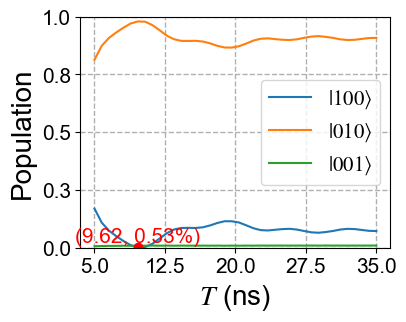

91.56896551724138


In [77]:
# 筛选出 X 值等于 2 的所有行
# filtered_data = df[df['X'] == x_min]

filtered_data = df[df['X'] == g_scale_sweep[g_idx]]


# 提取对应的 Y 和 Z 列
y_values = filtered_data['Y'].values
z100_values = filtered_data['Z100'].values
z010_values = filtered_data['Z010'].values
z001_values = filtered_data['Z001'].values
error_vals = filtered_data['target'].values


plt.figure(figsize=(4, 3))
plt.plot(y_values, z100_values, label=r'$|100\rangle$')
plt.plot(y_values, z010_values, label=r'$|010\rangle$')
plt.plot(y_values, z001_values, label=r'$|001\rangle$')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)

# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1


# 找到 z001_values 的最小值及其索引
min_value = np.min(error_vals)
min_index = np.argmin(error_vals)

# 找到对应的 x 坐标
min_x = y_values[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, y_values.max(), num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)
plt.show()
print(1000 * g0c * g_scale_sweep[g_idx])

# Linear

In [78]:
# local adiabatic
fct_sweep = np.linspace(5.300, 4.600, 30)
# g_scale_sweep = np.linspace(1, 5, 10)
duration_sweep = np.linspace(5, 35, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0


X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_reset_e_lin_100 = np.zeros_like(X)
Z_reset_e_lin_010 = np.zeros_like(X)
Z_reset_e_lin_001 = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0
    yt = fq0 - fct_fc0 - fc0
    pulse_fq_fct_array = np.linspace(y0, yt, ceil(duration / dt))
    pulse_fct_fc0_array = - pulse_fq_fct_array + fq0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_reset_e_lin_100[_idx] = result.expect[0][-1]    
    Z_reset_e_lin_010[_idx] = result.expect[1][-1]    
    Z_reset_e_lin_001[_idx] = result.expect[2][-1]   

100%|██████████| 1200/1200 [00:23<00:00, 51.97it/s]


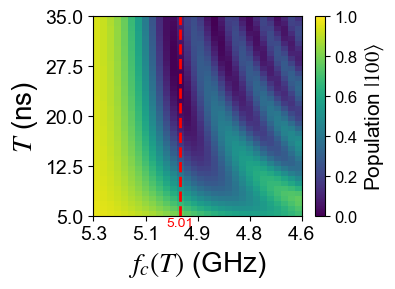

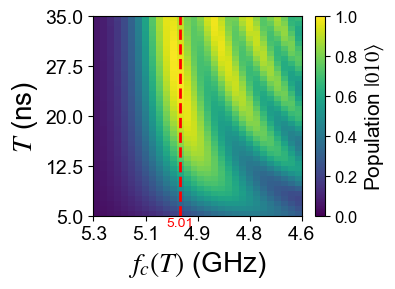

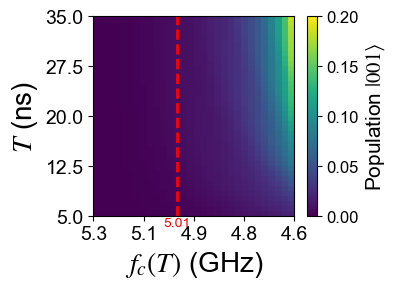

In [79]:

x_line = 5.01
plot_bar(fct_sweep, duration_sweep, Z_reset_e_lin_100, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|100\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_reset_e_lin_010, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|010\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_reset_e_lin_001, vmax=0.2, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|001\rangle$', figsize=(4, 3))



In [80]:
X_flat = X.ravel()
Y_flat = Y.ravel()
Z100_flat = Z_reset_e_lin_100.ravel()
Z010_flat = Z_reset_e_lin_010.ravel()
Z001_flat = Z_reset_e_lin_001.ravel()
target = 0.5 * Z100_flat + 0.5 * Z001_flat

# 将数据存入 pandas DataFrame
df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z100': Z100_flat, 'Z010': Z010_flat, 'Z001': Z001_flat, 'target': target})

# 找到 Z 最小值对应的行
min_z_row = df.loc[df['target'].idxmin()]

# 输出 Z 最小值及其对应的 X 和 Y 值
x_min, y_min, z_min = min_z_row['X'], min_z_row['Y'], min_z_row['target']
print(f"Z最小值为 {z_min}，对应的X值为 {x_min + fc0}，Y值为 {y_min}")

Z最小值为 0.005438942700633443，对应的X值为 5.010344827586207，Y值为 24.230769230769234


In [81]:
# 筛选出 X 值等于 2 的所有行
filtered_data = df[df['X'] == x_min]

# filtered_data = df[df['X'] == fq0 - fct_value]


# 提取对应的 Y 和 Z 列
y_values = filtered_data['Y'].values
z100_values = filtered_data['Z100'].values
z010_values = filtered_data['Z010'].values
z001_values = filtered_data['Z001'].values
error_vals = z100_values + z001_values

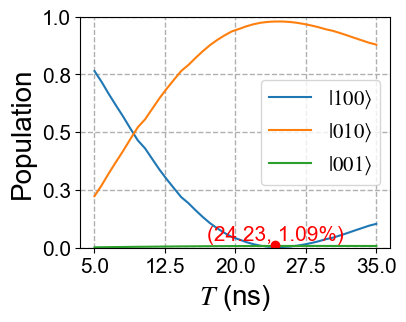

In [82]:
plt.figure(figsize=(4,3))

plt.plot(y_values, z100_values, label=r'$|100\rangle$')
plt.plot(y_values, z010_values, label=r'$|010\rangle$')
plt.plot(y_values, z001_values, label=r'$|001\rangle$')
plt.grid(linestyle = '--', linewidth = 1.0)


# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1
plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)

# 找到 z001_values 的最小值及其索引
min_value = np.min(error_vals)
min_index = np.argmin(error_vals)

# 找到对应的 x 坐标
min_x = y_values[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值


x_ticks = np.linspace(5.0, y_values.max(), num=5)
y_ticks = np.linspace(0.0, 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15)  

plt.legend(fontsize=15)
plt.show()

# Reset f

In [83]:
fct_sweep = np.linspace(5.300, 4.600, 30)
# g_scale_sweep = np.linspace(1, 5, 10)
duration_sweep = np.linspace(5, 100, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0
psi_init = psi_init_200_eigen
expt_op = [psi_init_200_eigen * psi_init_200_eigen.dag(), psi_init_020_eigen * psi_init_020_eigen.dag(), psi_init_110_eigen * psi_init_110_eigen.dag()]


In [84]:
# local adiabatic
X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_local_reset_f_200 = np.zeros_like(X)
Z_local_reset_f_020 = np.zeros_like(X)
Z_local_reset_f_110 = np.zeros_like(X)
Z_reset_f_leakage = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0 + 0.5 * anharm_q0
    yt = fq0 - fct_fc0 - fc0 + 0.5 * anharm_q0

    g_scale_swt = 1.0
    time, delta_swt = generate_local_adiabatic_pulse_swt(y0, yt, duration, np.sqrt(2) * g0c, dt, anharm=a_val, scale=g_scale_swt)
    pulse_fct_fc0_array = - delta_swt + fq0 + 0.5 * anharm_q - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    # times = np.linspace(0, time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, time, e_ops=expt_op)
    Z_local_reset_f_200[_idx] = result.expect[0][-1]    
    Z_local_reset_f_020[_idx] = result.expect[1][-1]    
    Z_local_reset_f_110[_idx] = result.expect[2][-1]    
    Z_reset_f_leakage[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1])


100%|██████████| 1200/1200 [05:34<00:00,  3.59it/s]


In [85]:
print(detunig_fct_fc0_sweep + fc0)
x_idx = 19
print(detunig_fct_fc0_sweep[x_idx] + fc0)
x_line = detunig_fct_fc0_sweep[x_idx] + fc0

[5.3        5.27586207 5.25172414 5.22758621 5.20344828 5.17931034
 5.15517241 5.13103448 5.10689655 5.08275862 5.05862069 5.03448276
 5.01034483 4.9862069  4.96206897 4.93793103 4.9137931  4.88965517
 4.86551724 4.84137931 4.81724138 4.79310345 4.76896552 4.74482759
 4.72068966 4.69655172 4.67241379 4.64827586 4.62413793 4.6       ]
4.841379310344827


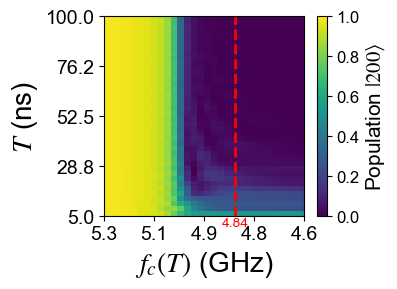

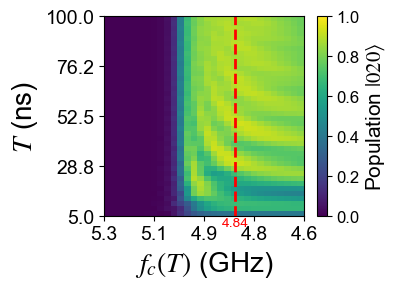

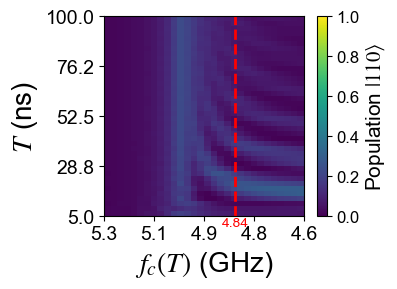

In [86]:
plot_bar(fct_sweep, duration_sweep, Z_local_reset_f_200, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|200\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_reset_f_020, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|020\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_reset_f_110, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|110\rangle$', figsize=(4, 3))

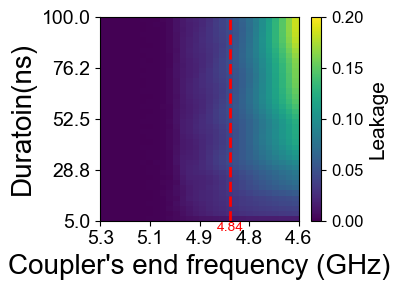

In [87]:
plot_bar(fct_sweep, duration_sweep, Z_reset_f_leakage, x_line=x_line, vmax=0.2, label_x='Coupler\'s end frequency (GHz)', label_y='Duratoin(ns)', label_bar=r'Leakage', figsize=(4, 3))


In [88]:
_, pop200 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_f_200, x_idx=x_idx)
_, pop020 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_f_020, x_idx=x_idx)
_, pop110 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_f_110, x_idx=x_idx)
_, popleak = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_f_leakage, x_idx=x_idx)

error = popleak + pop200 + pop110

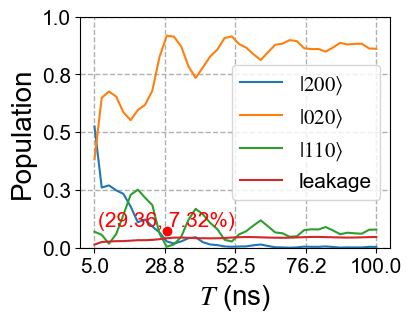

In [89]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, pop200, label=r'$|200\rangle$')
plt.plot(duration_sweep, pop020, label=r'$|020\rangle$')
plt.plot(duration_sweep, pop110, label=r'$|110\rangle$')
plt.plot(duration_sweep, popleak, label=r'leakage')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)
# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error)
min_index = np.argmin(error)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 

plt.legend(fontsize=15)

plt.show()

In [90]:
# Sweep g and duration
g_scale_sweep = np.linspace(0.1, 2.0, 40)

duration_sweep = np.linspace(5, 100, 40)

In [91]:
# local adiabatic
X, Y = np.meshgrid(g_scale_sweep, duration_sweep)
Z_g_reset_f_200 = np.zeros_like(X)
Z_g_reset_f_020 = np.zeros_like(X)
Z_g_reset_f_110 = np.zeros_like(X)
Z_g_reset_f_leakage = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    g_scale = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0 + 0.5 * anharm_q0
    # yt = fq0 - 4.84 + 0.5 * anharm_q0
    yt = fq0 - 4.84 + 0.5 * anharm_q0


    time, delta_swt = generate_local_adiabatic_pulse_swt(y0, yt, duration, np.sqrt(2) * g0c, dt, anharm=a_val, scale=g_scale)
    pulse_fct_fc0_array = - delta_swt + fq0 + 0.5 * anharm_q - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    # times = np.linspace(0, time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, time, e_ops=expt_op)
    Z_g_reset_f_200[_idx] = result.expect[0][-1]    
    Z_g_reset_f_020[_idx] = result.expect[1][-1]    
    Z_g_reset_f_110[_idx] = result.expect[2][-1]    
    Z_g_reset_f_leakage[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1])


100%|██████████| 1600/1600 [05:17<00:00,  5.04it/s]


In [92]:
x_idx = 20
x_line = 1e3 * g_scale_sweep[x_idx] * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0

In [93]:
g_swt_eff = 2 * np.sqrt(2) * g0c ** 2 / -anharm_q0
g_swt_eff

0.024406232494391934

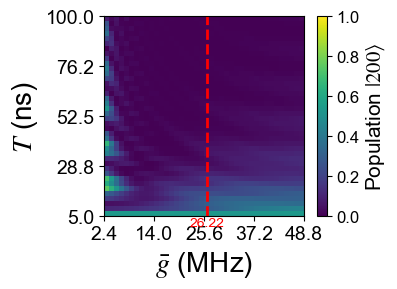

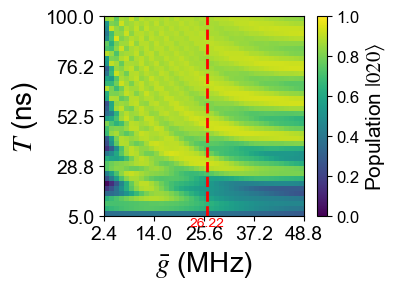

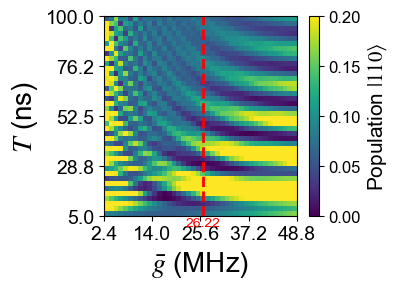

In [94]:
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_g_reset_f_200, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|200\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2 / -anharm_q0, duration_sweep, Z_g_reset_f_020, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|020\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2 / -anharm_q0, duration_sweep, Z_g_reset_f_110, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', vmax=0.2,label_y=r'$T$ (ns)', label_bar=r'Population $|110\rangle$', min2max=True, figsize=(4, 3))

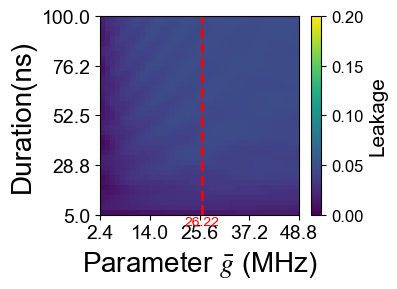

In [95]:
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2 / -anharm_q0, duration_sweep, Z_g_reset_f_leakage,  x_line=x_line, vmax=0.2, label_x=r'Parameter $\bar{g}$ (MHz)', label_y='Duration(ns)', label_bar=r'Leakage', min2max=True, figsize=(4, 3))

In [96]:
g_scale_sweep

array([0.1       , 0.14871795, 0.1974359 , 0.24615385, 0.29487179,
       0.34358974, 0.39230769, 0.44102564, 0.48974359, 0.53846154,
       0.58717949, 0.63589744, 0.68461538, 0.73333333, 0.78205128,
       0.83076923, 0.87948718, 0.92820513, 0.97692308, 1.02564103,
       1.07435897, 1.12307692, 1.17179487, 1.22051282, 1.26923077,
       1.31794872, 1.36666667, 1.41538462, 1.46410256, 1.51282051,
       1.56153846, 1.61025641, 1.65897436, 1.70769231, 1.75641026,
       1.80512821, 1.85384615, 1.9025641 , 1.95128205, 2.        ])

In [97]:
_, pop200_g = return_z_line(g_scale_sweep, duration_sweep, Z_g_reset_f_200, x_idx=x_idx)
_, pop020_g = return_z_line(g_scale_sweep, duration_sweep, Z_g_reset_f_020, x_idx=x_idx)
_, pop110_g = return_z_line(g_scale_sweep, duration_sweep, Z_g_reset_f_110, x_idx=x_idx)
_, popleak_g = return_z_line(g_scale_sweep, duration_sweep, Z_g_reset_f_leakage, x_idx=x_idx)

error = pop200_g + pop110_g + popleak_g


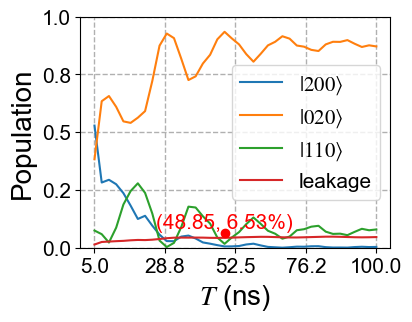

In [98]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, pop200_g, label=r'$|200\rangle$')
plt.plot(duration_sweep, pop020_g, label=r'$|020\rangle$')
plt.plot(duration_sweep, pop110_g, label=r'$|110\rangle$')
# plt.plot(duration_sweep, pop110_g + pop200_g, label=r'$|110\rangle$')

plt.plot(duration_sweep, popleak_g, label=r'leakage')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)


# 设置 y 轴刻度
plt.yticks(np.arange(0., 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error)
min_index = np.argmin(error)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值

x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.0, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)
plt.ylim(0, 1)

plt.show()

In [99]:
# Linear
X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_reset_f_linear_200 = np.zeros_like(X)
Z_reset_f_linear_020 = np.zeros_like(X)
Z_reset_f_linear_110 = np.zeros_like(X)
Z_reset_f_linear_leakage = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0
    yt = fq0 - fct_fc0 - fc0
    pulse_fq_fct_array = np.linspace(y0, yt, ceil(duration / dt))
    pulse_fct_fc0_array = - pulse_fq_fct_array + fq0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_reset_f_linear_200[_idx] = result.expect[0][-1]    
    Z_reset_f_linear_020[_idx] = result.expect[1][-1]    
    Z_reset_f_linear_110[_idx] = result.expect[2][-1]   
    Z_reset_f_linear_leakage[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1])


100%|██████████| 1200/1200 [01:28<00:00, 13.56it/s]


In [100]:
print(fct_sweep)
x_idx = 19
x_line = fct_sweep[x_idx]
print(fct_sweep[x_idx])

[5.3        5.27586207 5.25172414 5.22758621 5.20344828 5.17931034
 5.15517241 5.13103448 5.10689655 5.08275862 5.05862069 5.03448276
 5.01034483 4.9862069  4.96206897 4.93793103 4.9137931  4.88965517
 4.86551724 4.84137931 4.81724138 4.79310345 4.76896552 4.74482759
 4.72068966 4.69655172 4.67241379 4.64827586 4.62413793 4.6       ]
4.841379310344827


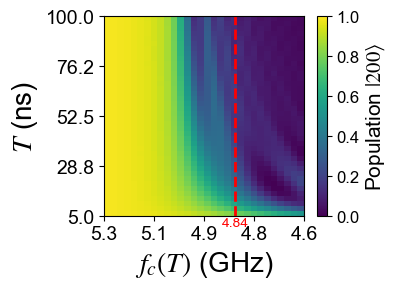

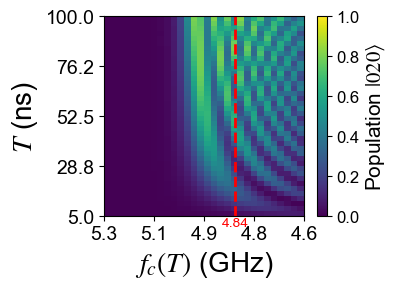

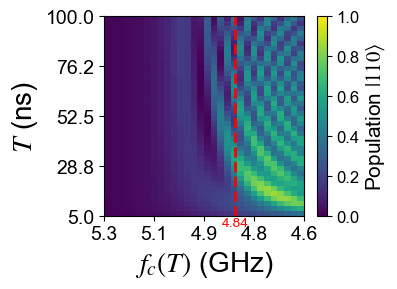

In [101]:
plot_bar(fct_sweep, duration_sweep, Z_reset_f_linear_200, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|200\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_reset_f_linear_020, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|020\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_reset_f_linear_110, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|110\rangle$', figsize=(4, 3))

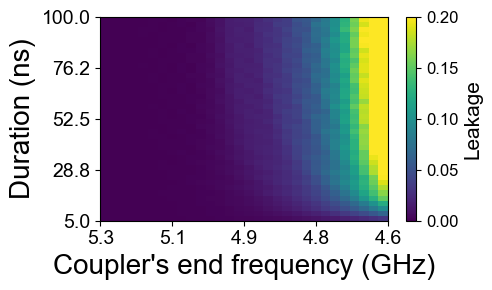

In [102]:
plot_bar(fct_sweep, duration_sweep, Z_reset_f_linear_leakage, vmax=0.2, label_x='Coupler\'s end frequency (GHz)', label_y='Duration (ns)', label_bar=r'Leakage', figsize=(5, 3))


In [103]:
fct_sweep

array([5.3       , 5.27586207, 5.25172414, 5.22758621, 5.20344828,
       5.17931034, 5.15517241, 5.13103448, 5.10689655, 5.08275862,
       5.05862069, 5.03448276, 5.01034483, 4.9862069 , 4.96206897,
       4.93793103, 4.9137931 , 4.88965517, 4.86551724, 4.84137931,
       4.81724138, 4.79310345, 4.76896552, 4.74482759, 4.72068966,
       4.69655172, 4.67241379, 4.64827586, 4.62413793, 4.6       ])

In [104]:
_, pop200_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_f_linear_200, x_idx=x_idx)
_, pop020_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_f_linear_020, x_idx=x_idx)
_, pop110_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_f_linear_110, x_idx=x_idx)
_, popleak_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_f_linear_leakage, x_idx=x_idx)
error_reset_f_lin = popleak_lin + pop200_lin + pop110_lin

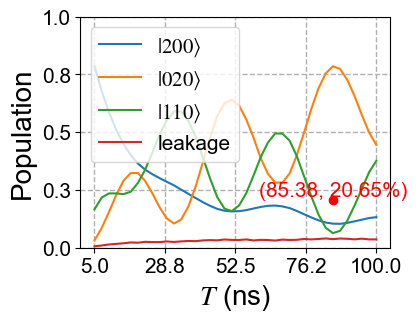

In [105]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, pop200_lin, label=r'$|200\rangle$')
plt.plot(duration_sweep, pop020_lin, label=r'$|020\rangle$')
plt.plot(duration_sweep, pop110_lin, label=r'$|110\rangle$')
plt.plot(duration_sweep, popleak_lin, label=r'leakage')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel('Population', size=size)
# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error_reset_f_lin)
min_index = np.argmin(error_reset_f_lin)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)

plt.show()

# Reset e + f

In [106]:
fct_sweep = np.linspace(5.300, 4.600, 30)
duration_sweep = np.linspace(5, 100, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0
psi_init = psi_init_200_eigen + psi_init_100_eigen
expt_op = [psi_init_200_eigen * psi_init_200_eigen.dag(), psi_init_020_eigen * psi_init_020_eigen.dag(), psi_init_110_eigen * psi_init_110_eigen.dag(), psi_init_100_eigen * psi_init_100_eigen.dag(), psi_init_010_eigen * psi_init_010_eigen.dag()]


In [107]:
# local adiabatic
X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_local_reset_ef_200 = np.zeros_like(X)
Z_local_reset_ef_020 = np.zeros_like(X)
Z_local_reset_ef_110 = np.zeros_like(X)
Z_local_reset_ef_100 = np.zeros_like(X)
Z_local_reset_ef_010 = np.zeros_like(X)

Z_reset_ef_leakage = np.zeros_like(X)

for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0 + 0.5 * anharm_q0
    yt = fq0 - fct_fc0 - fc0 + 0.5 * anharm_q0

    g_scale_swt = 1.0
    time, delta_swt = generate_local_adiabatic_pulse_swt(y0, yt, duration, np.sqrt(2) * g0c, dt, anharm=a_val, scale=g_scale_swt)
    pulse_fct_fc0_array = - delta_swt + fq0 + 0.5 * anharm_q - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    # times = np.linspace(0, time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, time, e_ops=expt_op)
    Z_local_reset_ef_200[_idx] = result.expect[0][-1]    
    Z_local_reset_ef_020[_idx] = result.expect[1][-1]    
    Z_local_reset_ef_110[_idx] = result.expect[2][-1]
    Z_local_reset_ef_100[_idx] = result.expect[3][-1]    
    Z_local_reset_ef_010[_idx] = result.expect[4][-1]    

    Z_reset_ef_leakage[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1]+ result.expect[3][-1]+ result.expect[4][-1])


100%|██████████| 1200/1200 [02:42<00:00,  7.39it/s]


In [108]:
print(detunig_fct_fc0_sweep + fc0)
x_idx = 19
x_line = detunig_fct_fc0_sweep[x_idx] + fc0
print(x_line)


[5.3        5.27586207 5.25172414 5.22758621 5.20344828 5.17931034
 5.15517241 5.13103448 5.10689655 5.08275862 5.05862069 5.03448276
 5.01034483 4.9862069  4.96206897 4.93793103 4.9137931  4.88965517
 4.86551724 4.84137931 4.81724138 4.79310345 4.76896552 4.74482759
 4.72068966 4.69655172 4.67241379 4.64827586 4.62413793 4.6       ]
4.841379310344827


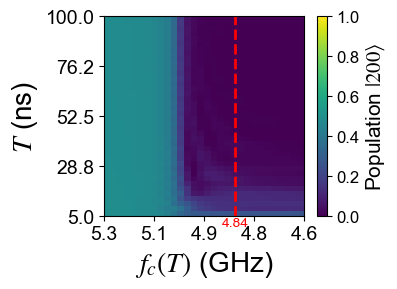

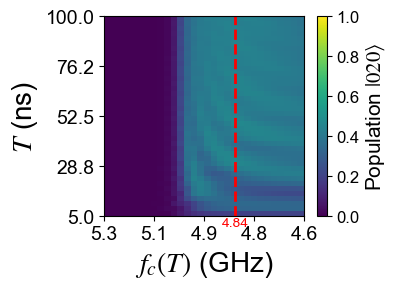

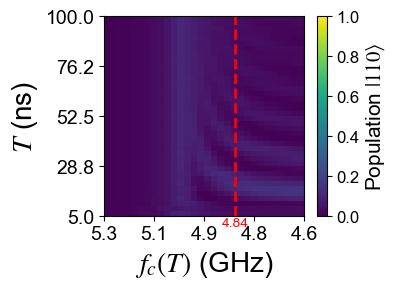

In [109]:
plot_bar(fct_sweep, duration_sweep, Z_local_reset_ef_200, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|200\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_reset_ef_020, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|020\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_reset_ef_110, x_line=x_line, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|110\rangle$', figsize=(4, 3))

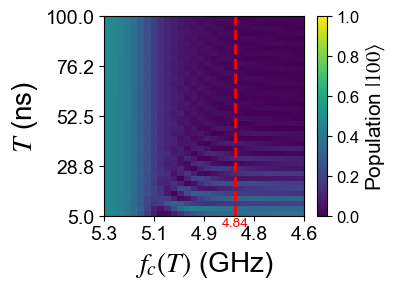

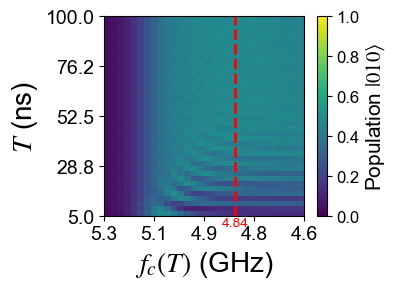

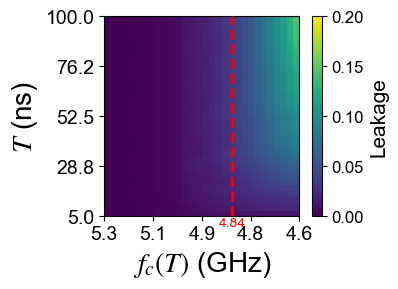

In [110]:
plot_bar(fct_sweep, duration_sweep, Z_local_reset_ef_100, label_x=r'$f_c(T)$ (GHz)', x_line=x_line, label_y=r'$T$ (ns)', label_bar=r'Population $|100\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_local_reset_ef_010, label_x=r'$f_c(T)$ (GHz)', x_line=x_line, label_y=r'$T$ (ns)', label_bar=r'Population $|010\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_reset_ef_leakage, x_line=x_line, vmax=0.2, label_x=r'$f_c(T)$ (GHz)', label_y=r'$T$ (ns)', label_bar=r'Leakage', figsize=(4, 3))


In [111]:
_, pop_ef_200 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_ef_200, x_idx=x_idx)
_, pop_ef_020 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_ef_020, x_idx=x_idx)
_, pop_ef_110 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_ef_110, x_idx=x_idx)
_, pop_ef_010 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_ef_010, x_idx=x_idx)
_, pop_ef_100 = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_local_reset_ef_100, x_idx=x_idx)

_, pop_ef_leak = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_reset_ef_leakage, x_idx=x_idx)

qubit_pop = pop_ef_200 + pop_ef_100 + pop_ef_110
coupler_pop = pop_ef_020 + pop_ef_010
error = pop_ef_leak + qubit_pop

In [112]:
print(1-(Z_local_reset_ef_020 + Z_local_reset_ef_010).max())

0.05130303237438816


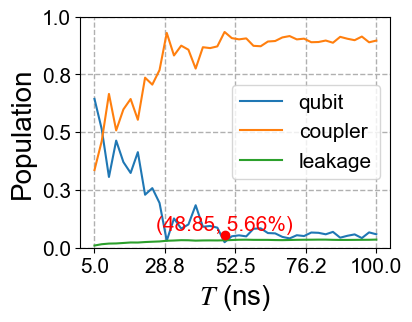

In [113]:
plt.figure(figsize=(4, 3))
# plt.plot(duration_sweep, pop_ef_200, label=r'$|200\rangle$')
# plt.plot(duration_sweep, pop_ef_020, label=r'$|020\rangle$')
# plt.plot(duration_sweep, pop_ef_110, label=r'$|110\rangle$')
# plt.plot(duration_sweep, pop_ef_leak, label=r'leakage')

plt.plot(duration_sweep, qubit_pop, label=r'qubit')
plt.plot(duration_sweep, coupler_pop, label=r'coupler')
plt.plot(duration_sweep, pop_ef_leak, label=r'leakage')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel(r'$T$ (ns)', size=size)
plt.ylabel(r'Population', size=size)
# 设置 y 轴范围
plt.ylim(0, 1)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error)
min_index = np.argmin(error)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)

plt.show()

In [114]:
fct_sweep = np.linspace(5.300, 4.600, 30)
# g_scale_sweep = np.linspace(1, 5, 10)
duration_sweep = np.linspace(5, 100, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0
psi_init = psi_init_200_eigen + psi_init_100_eigen
expt_op = [psi_init_200_eigen * psi_init_200_eigen.dag(), psi_init_020_eigen * psi_init_020_eigen.dag(), psi_init_110_eigen * psi_init_110_eigen.dag(), psi_init_100_eigen * psi_init_100_eigen.dag(), psi_init_010_eigen * psi_init_010_eigen.dag()]


In [115]:
g_scale_sweep = np.linspace(0.1, 2.0, 30)

duration_sweep = np.linspace(5, 100, 40)


In [116]:
# local adiabatic
X, Y = np.meshgrid(g_scale_sweep, duration_sweep)
Z_ef_200 = np.zeros_like(X)
Z_ef_020 = np.zeros_like(X)
Z_ef_110 = np.zeros_like(X)
Z_ef_100 = np.zeros_like(X)
Z_ef_010 = np.zeros_like(X)
Z_ef_leak = np.zeros_like(X)


for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    g_scale = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0 + 0.5 * anharm_q0
    yt = fq0 - 4.84 + 0.5 * anharm_q0
    time, delta_swt = generate_local_adiabatic_pulse_swt(y0, yt, duration, np.sqrt(2) * g0c, dt, anharm=anharm_q0, scale=g_scale)
    pulse_fct_fc0_array = - delta_swt + fq0 + 0.5 * anharm_q0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_ef_200[_idx] = result.expect[0][-1]    
    Z_ef_020[_idx] = result.expect[1][-1]    
    Z_ef_110[_idx] = result.expect[2][-1]  
    Z_ef_100[_idx] = result.expect[3][-1]    
    Z_ef_010[_idx] = result.expect[4][-1]    
    Z_ef_leak[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1] + result.expect[3][-1] + result.expect[4][-1])



100%|██████████| 1200/1200 [02:13<00:00,  8.99it/s]


In [117]:
x_idx = 20

x_line = 1e3 * g_scale_sweep[x_idx] * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0
print(x_line)
print(f'geff: {1e3 * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0}')

34.421203759332066
geff: 24.40623249439193


In [118]:
_, pop200_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_200, x_idx=x_idx)
_, pop020_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_020, x_idx=x_idx)
_, pop110_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_110, x_idx=x_idx)
_, pop100_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_100, x_idx=x_idx)
_, pop010_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_010, x_idx=x_idx)
_, popleak_ef = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_leak, x_idx=x_idx)


print(x_line)

34.421203759332066


In [119]:
print(1-(Z_ef_020 + Z_ef_010).max())

0.051865476393035626


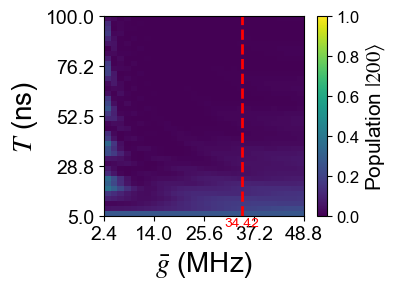

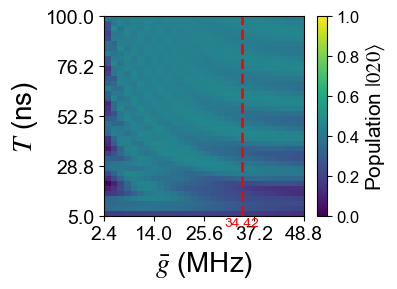

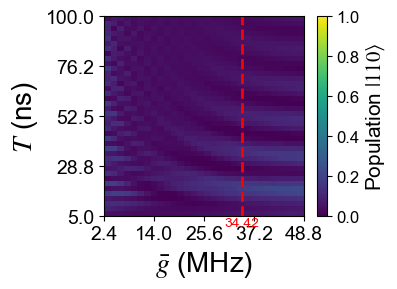

In [120]:
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_200, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|200\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_020, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|020\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_110, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|110\rangle$', min2max=True, figsize=(4, 3))



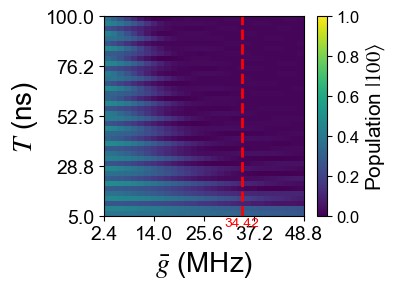

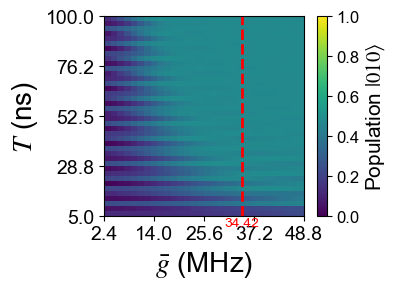

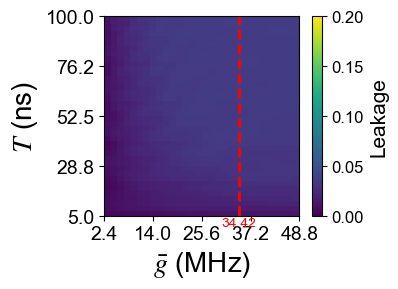

In [121]:
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_100, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|100\rangle$', min2max=True, figsize=(4, 3))
plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_010, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y=r'$T$ (ns)', label_bar=r'Population $|010\rangle$', min2max=True, figsize=(4, 3))

plot_bar(1e3 * g_scale_sweep * 2 * np.sqrt(2) * g0c ** 2  / -anharm_q0, duration_sweep, Z_ef_leak, vmax=0.2, x_line=x_line, label_x=r'$\bar{g}$ (MHz)', label_y='$T$ (ns)', label_bar=r'Leakage', min2max=True, figsize=(4, 3))


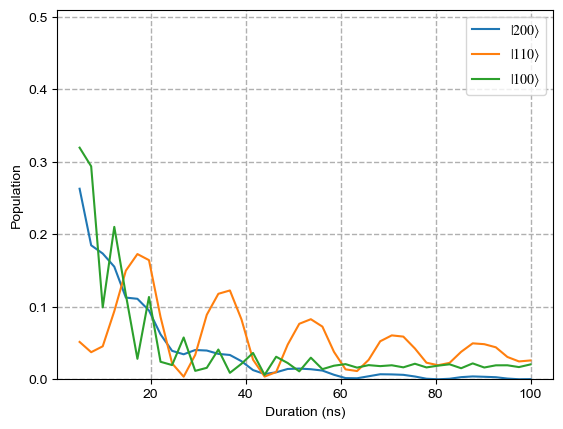

In [122]:
plt.plot(duration_sweep, pop200_ef, label=r'$|200\rangle$')
plt.plot(duration_sweep, pop110_ef, label=r'$|110\rangle$')
plt.plot(duration_sweep, pop100_ef, label=r'$|100\rangle$')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('Duration (ns)')
plt.ylabel('Population')

# 设置 y 轴范围
plt.ylim(0, 0.51)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 0.51, 0.1))  # 从 0 到 1，间隔为 0.1

plt.legend()

plt.show()

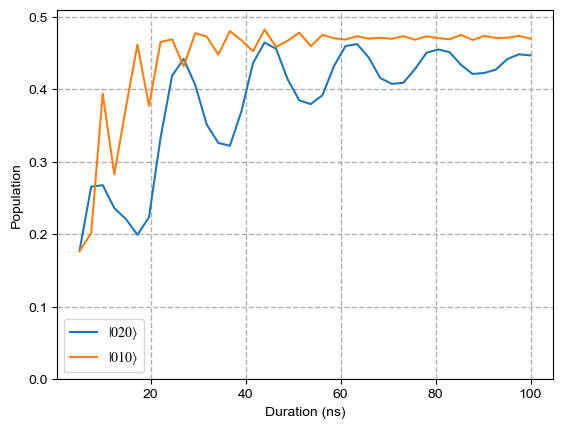

In [123]:
plt.plot(duration_sweep, pop020_ef, label=r'$|020\rangle$')
# plt.plot(duration_sweep, pop020_ef, label=r'$|020\rangle$')
plt.plot(duration_sweep, pop010_ef, label=r'$|010\rangle$')

# plt.plot(duration_sweep, pop010_ef, label=r'$|010\rangle$')

# plt.plot(duration_sweep, popleak_g, label=r'leakage')


plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('Duration (ns)')
plt.ylabel('Population')

# 设置 y 轴范围
plt.ylim(0, 0.51)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 0.51, 0.1))  # 从 0 到 1，间隔为 0.1

plt.legend()

plt.show()

In [124]:
qubit_pop = pop200_ef + pop100_ef + pop110_ef
coupler_pop = pop020_ef + pop010_ef
leak_pop = 1 - (qubit_pop + coupler_pop)
error_pop = qubit_pop + leak_pop

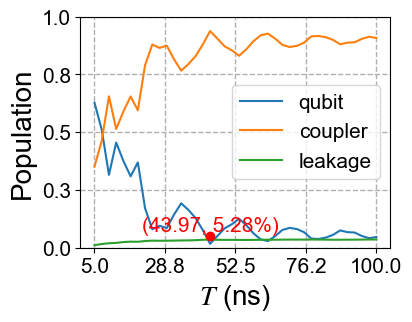

In [125]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, qubit_pop, label=r'qubit')
plt.plot(duration_sweep, coupler_pop, label=r'coupler')
plt.plot(duration_sweep, leak_pop, label=r'leakage')




plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('$T$ (ns)', size=size)
plt.ylabel('Population', size=size)

# 设置 y 轴范围
plt.ylim(0, 1.0)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error_pop)
min_index = np.argmin(error_pop)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value + 0.02, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)

plt.show()

Linear

In [126]:
# Linear

fct_sweep = np.linspace(5.300, 4.600, 30)
# g_scale_sweep = np.linspace(1, 5, 10)
duration_sweep = np.linspace(5, 100, 40)
detunig_fct_fc0_sweep = fct_sweep - fc0

X, Y = np.meshgrid(detunig_fct_fc0_sweep, duration_sweep)
Z_ef_linear_200 = np.zeros_like(X)
Z_ef_linear_020 = np.zeros_like(X)
Z_ef_linear_110 = np.zeros_like(X)
Z_ef_linear_100 = np.zeros_like(X)
Z_ef_linear_010 = np.zeros_like(X)
Z_ef_liner_leak = np.zeros_like(X)


for _idx in tqdm(list(np.ndindex(X.shape))):
    sched = Schedule(sampling_rate=dt)
    fct_fc0 = X[_idx]
    duration = Y[_idx]
    y0 = fq0 - fc0
    yt = fq0 - fct_fc0 - fc0
    pulse_fq_fct_array = np.linspace(y0, yt, ceil(duration / dt))
    pulse_fct_fc0_array = - pulse_fq_fct_array + fq0 - fc0
    sched.append_list(list(pulse_fct_fc0_array))
    H_adiabatic = [H2, [Hd, sched.sequence]]
    times = np.linspace(0, sched.time, len(sched.sequence))
    result = mesolve(H_adiabatic, psi_init, times, e_ops=expt_op)
    Z_ef_linear_200[_idx] = result.expect[0][-1]    
    Z_ef_linear_020[_idx] = result.expect[1][-1]    
    Z_ef_linear_110[_idx] = result.expect[2][-1]   
    Z_ef_linear_100[_idx] = result.expect[3][-1]   
    Z_ef_linear_010[_idx] = result.expect[4][-1]   
    Z_ef_liner_leak[_idx] = 1 - (result.expect[0][-1] + result.expect[1][-1] + result.expect[2][-1] + result.expect[3][-1] + result.expect[4][-1])


100%|██████████| 1200/1200 [01:28<00:00, 13.59it/s]


In [127]:
x_idx = 19
x_line = detunig_fct_fc0_sweep[x_idx] + fc0
print(f'End freq: {detunig_fct_fc0_sweep[x_idx] + fc0}')

End freq: 4.841379310344827


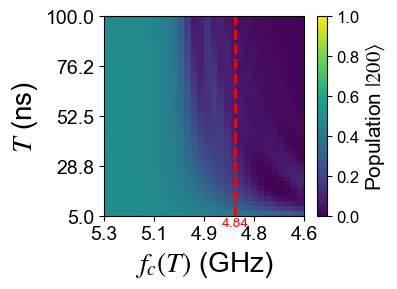

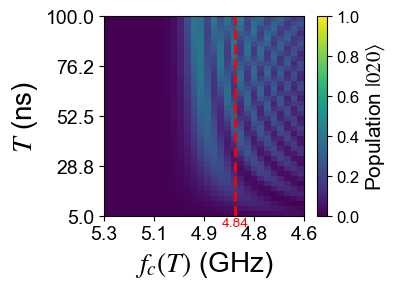

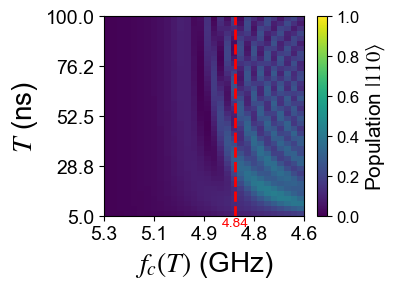

In [128]:
plot_bar(fct_sweep, duration_sweep, Z_ef_linear_200, x_line=x_line, label_x='$f_c(T)$ (GHz)', label_y='$T$ (ns)', label_bar=r'Population $|200\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_ef_linear_020, x_line=x_line, label_x='$f_c(T)$ (GHz)', label_y='$T$ (ns)', label_bar=r'Population $|020\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_ef_linear_110, x_line=x_line, label_x='$f_c(T)$ (GHz)', label_y='$T$ (ns)', label_bar=r'Population $|110\rangle$', figsize=(4, 3))

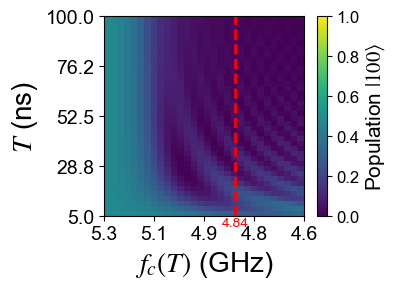

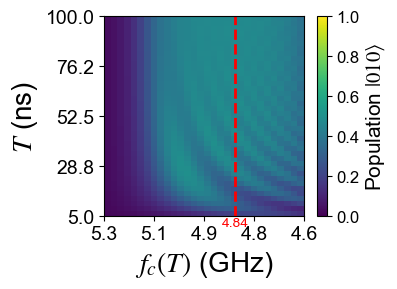

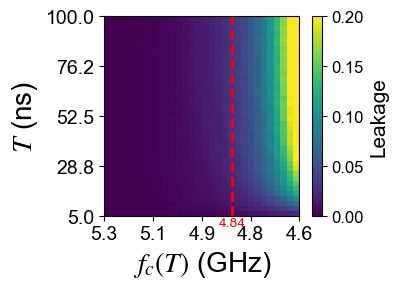

In [129]:
plot_bar(fct_sweep, duration_sweep, Z_ef_linear_100, label_x='$f_c(T)$ (GHz)', x_line=x_line, label_y='$T$ (ns)', label_bar=r'Population $|100\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_ef_linear_010, label_x='$f_c(T)$ (GHz)', x_line=x_line, label_y='$T$ (ns)', label_bar=r'Population $|010\rangle$', figsize=(4, 3))
plot_bar(fct_sweep, duration_sweep, Z_ef_liner_leak, label_x='$f_c(T)$ (GHz)', x_line=x_line, vmax=0.2, label_y='$T$ (ns)', label_bar=r'Leakage', figsize=(4, 3))


In [130]:
print(1-(Z_ef_linear_020 + Z_ef_linear_010).max())

0.12656911213636768


In [131]:
detunig_fct_fc0_sweep + fc0

array([5.3       , 5.27586207, 5.25172414, 5.22758621, 5.20344828,
       5.17931034, 5.15517241, 5.13103448, 5.10689655, 5.08275862,
       5.05862069, 5.03448276, 5.01034483, 4.9862069 , 4.96206897,
       4.93793103, 4.9137931 , 4.88965517, 4.86551724, 4.84137931,
       4.81724138, 4.79310345, 4.76896552, 4.74482759, 4.72068966,
       4.69655172, 4.67241379, 4.64827586, 4.62413793, 4.6       ])

In [132]:

_, pop200_ef_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_linear_200, x_idx=x_idx)
_, pop020_ef_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_linear_020, x_idx=x_idx)
_, pop110_ef_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_linear_110, x_idx=x_idx)
_, pop100_ef_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_linear_100, x_idx=x_idx)
_, pop010_ef_lin = return_z_line(detunig_fct_fc0_sweep, duration_sweep, Z_ef_linear_010, x_idx=x_idx)





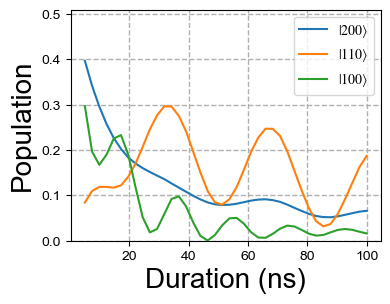

In [133]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, pop200_ef_lin, label=r'$|200\rangle$')
plt.plot(duration_sweep, pop110_ef_lin, label=r'$|110\rangle$')
plt.plot(duration_sweep, pop100_ef_lin, label=r'$|100\rangle$')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('Duration (ns)', size=size)
plt.ylabel('Population', size=size)

# 设置 y 轴范围
plt.ylim(0, 0.51)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 0.51, 0.1))  # 从 0 到 1，间隔为 0.1

plt.legend()

plt.show()

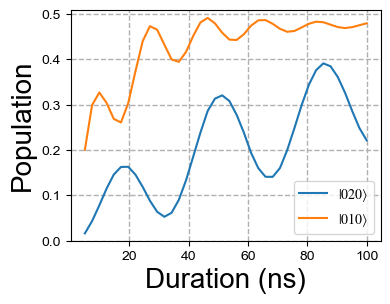

In [134]:
plt.figure(figsize=(4, 3))
plt.plot(duration_sweep, pop020_ef_lin, label=r'$|020\rangle$')
plt.plot(duration_sweep, pop010_ef_lin, label=r'$|010\rangle$')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('Duration (ns)', size=size)
plt.ylabel('Population', size=size)

# 设置 y 轴范围
plt.ylim(0, 0.51)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 0.51, 0.1))  # 从 0 到 1，间隔为 0.1

plt.legend()

plt.show()

In [135]:
qubit_pop_lin = pop200_ef_lin + pop100_ef_lin + pop110_ef_lin
coupler_pop_lin = pop020_ef_lin + pop010_ef_lin
leak_pop_lin = 1 - (qubit_pop_lin + coupler_pop_lin)
error = qubit_pop_lin + leak_pop_lin

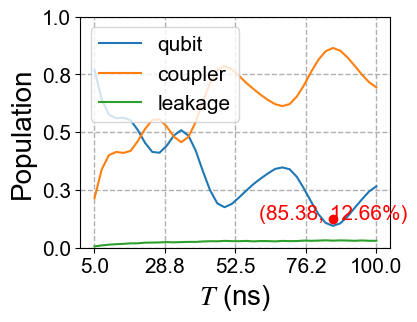

In [136]:
plt.figure(figsize=(4, 3))

plt.plot(duration_sweep, qubit_pop_lin, label=r'qubit')
plt.plot(duration_sweep, coupler_pop_lin, label=r'coupler')
plt.plot(duration_sweep, leak_pop_lin, label=r'leakage')

plt.grid(linestyle = '--', linewidth = 1.0)

plt.xlabel('$T$ (ns)', size=size)
plt.ylabel('Population', size=size)

# 设置 y 轴范围
plt.ylim(0, 1.0)

# 设置 y 轴刻度
plt.yticks(np.arange(0, 1.1, 0.1))  # 从 0 到 1，间隔为 0.1

# 找到 z001_values 的最小值及其索引
min_value = np.min(error)
min_index = np.argmin(error)

# 找到对应的 x 坐标
min_x = duration_sweep[min_index]

# 在图上标出最小值
plt.plot(min_x, min_value, 'ro')  # 用红色圆点标记最小值
plt.text(min_x, min_value, f'({min_x:.2f}, {min_value * 100:.2f}%)', color='red', ha='center', fontsize=15)  # 显示数值
x_ticks = np.linspace(5, duration_sweep[-1], num=5)
y_ticks = np.linspace(0., 1.01, num=5)

plt.xticks(ticks=x_ticks, labels=[f'{tick:.1f}' for tick in x_ticks], size=15)  
plt.yticks(ticks=y_ticks, labels=[f'{tick:.1f}' for tick in y_ticks], size=15) 
plt.legend(fontsize=15)
plt.show()